In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt
import numpy as np
from kernels import HMC_vanilla, HMC_our, Reverse_kernel

%matplotlib inline

import random

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS

In [2]:
def set_seeds(rand_seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)
    torch.cuda.manual_seed_all(rand_seed)

set_seeds(1)

In [3]:
class Encoder_vae(nn.Module):
    def __init__(self, data_dim, z_dim, K=8):
        super(Encoder_vae, self).__init__()
        self.h1 = nn.Linear(in_features=data_dim, out_features=K)
        self.h2 = nn.Linear(in_features=K, out_features=K)
        self.mu = nn.Linear(in_features=K, out_features=z_dim)
        self.sigma = nn.Linear(in_features=K, out_features=z_dim)
    def forward(self, x):
        h1 = F.selu(self.h1(x))
        h2 = F.selu(self.h2(h1))
        return self.mu(h2), F.softplus(self.sigma(h2))
    
class Decoder(nn.Module):
    def __init__(self, data_dim, z_dim):
        super(Decoder, self).__init__()
        self.W = nn.Linear(in_features=z_dim, out_features=data_dim, bias=False)
    def forward(self, z):
        return self.W(z)

# Notebook with simple experiments

## Task 1

### Receiving of the true $\theta$ and generating of a dataset

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

z_dim = 2 # Latent space dimensionality
data_dim = 10 # Data dimensionality
N = 10000 # Dataset size
N_val = 1000 # Validation Dataset

sigma_0 = 1. # True std

In [5]:
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
std_normal_pyro = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
true_theta = std_normal.sample((z_dim, data_dim)) * sigma_0
print('True decoder matrix')
print(true_theta)
print('-' * 100)

data_probs = torch.sigmoid(std_normal.sample((N, z_dim)) @ true_theta)
data = torch.distributions.Bernoulli(probs=data_probs).sample()

data_probs_val = torch.sigmoid(std_normal.sample((N_val, z_dim)) @ true_theta)
data_val = torch.distributions.Bernoulli(probs=data_probs_val).sample()

print('Generated data example:')
print(data[:10])

True decoder matrix
tensor([[-0.2963,  2.6764, -0.1408, -0.8441,  0.2905, -0.2838, -1.4535,  2.3737,
         -0.0177, -2.7884],
        [-0.3788,  0.7046, -1.3956, -0.1248, -0.9259, -1.5463, -0.4902,  0.0244,
         -1.5992, -0.8469]], device='cuda:0')
----------------------------------------------------------------------------------------------------
Generated data example:
tensor([[1., 0., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 0., 1., 1., 0., 0., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 0., 0., 1., 1.],
        [0., 1., 1., 1., 1., 1., 0., 1., 0., 1.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 1., 1.]], device='cuda:0')


In [6]:
print('!!!!!')
previous_theta = torch.tensor([[-0.296278  ,  2.676448  , -0.1408463 , -0.84409505,  0.29053846,
        -0.28383088, -1.4534557 ,  2.3736813 , -0.01774164, -2.7884495 ],
       [-0.37882465,  0.7045725 , -1.3956138 , -0.12478404, -0.9258568 ,
        -1.5463208 , -0.49016267,  0.02436782, -1.5992415 , -0.8468648 ]], dtype=torch.float32, device=device)
assert(np.abs(previous_theta.cpu().numpy() - true_theta.cpu().numpy()) < 1e-8).all()
print('OK!')

!!!!!
OK!


## Task 2

### Sample z with target $p(z|x)$, using NUTS

#### 1) Bernoulli likelihood from torch

In [7]:
n_warmup = 2000
n_samples = 1000

data_ind = 0  #  index of datapoint we conditioned on

In [8]:
def potential_fn(z):
    z = z['points']
    probs = torch.sigmoid(z @ true_theta)
    return -torch.sum(pyro.distributions.Bernoulli(probs=probs).log_prob(data[data_ind][None]).sum(1) + std_normal_pyro.log_prob(z).sum(1))

In [9]:
init_samples = std_normal_pyro.sample((1, z_dim))
init_params = {'points': init_samples}

nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel,
            initial_params=init_params,
            num_samples=n_samples,
            warmup_steps=n_warmup)

mcmc.run()
z = mcmc.get_samples()['points'].squeeze()

Sample: 100%|██████████| 3000/3000 [00:22, 133.99it/s, step size=8.18e-01, acc. prob=0.910]


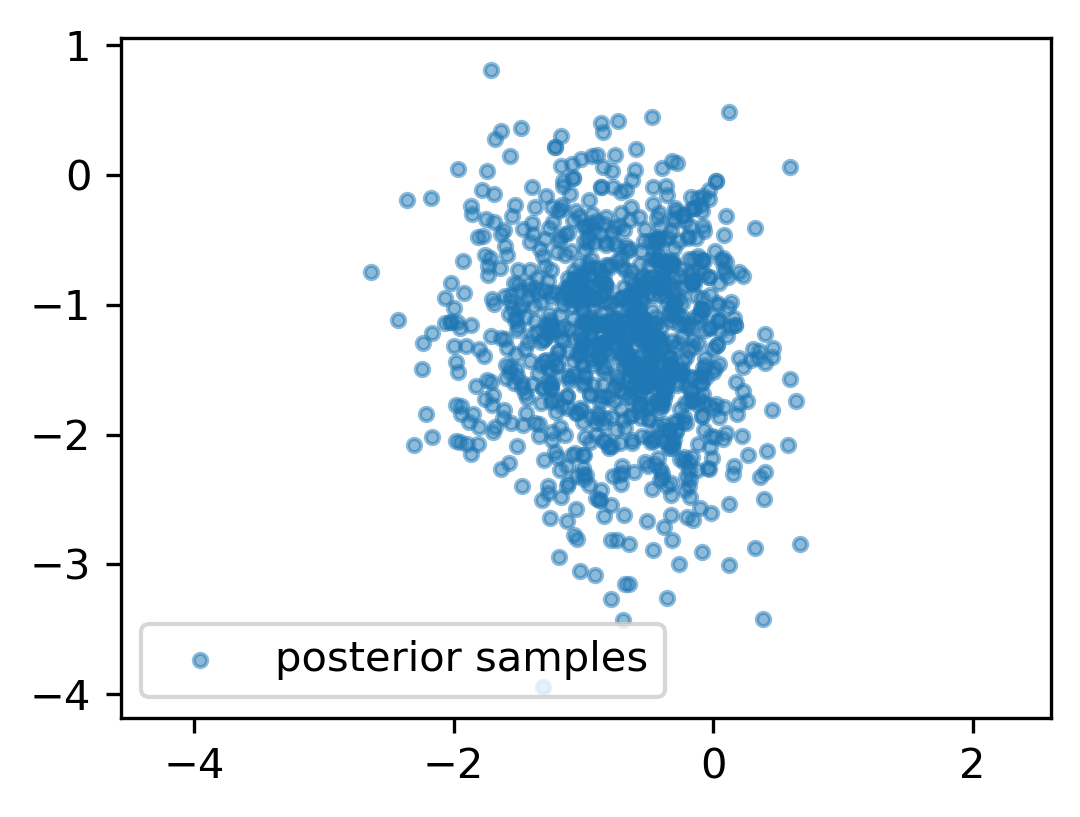

In [10]:
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), label='posterior samples', s=10, alpha=0.5)
plt.legend()
plt.axis('equal');

### Sample z with target $p(z|x)$, using our HMC

In [11]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict({})

args.device = device

args.N = 5

args.alpha = 0.5
args.use_partialref = False

args.gamma = 0.1
args.use_barker = False

In [12]:
class Target():
    def __init__(self,):
        pass
    def get_logdensity(self, z, x):
        probs = torch.sigmoid(z @ true_theta)
        return torch.distributions.Bernoulli(probs=probs).log_prob(x).sum(1) + std_normal.log_prob(z).sum(1)
target = Target()

In [13]:
transitions = HMC_vanilla(args)
z = std_normal.sample((1, z_dim))
momentum = std_normal.sample(z.shape)

print('Warm up')
for i in tqdm(range(n_warmup)):
    z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=data[data_ind][None])
    
print('Sampling')
samples = []
for i in tqdm(range(n_samples)):
    z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=data[data_ind][None])
    samples.append(z.cpu().detach().numpy())

  1%|          | 15/2000 [00:00<00:13, 149.20it/s]

Warm up


  2%|▏         | 15/1000 [00:00<00:06, 149.72it/s]

Sampling


100%|██████████| 1000/1000 [00:06<00:00, 149.64it/s]


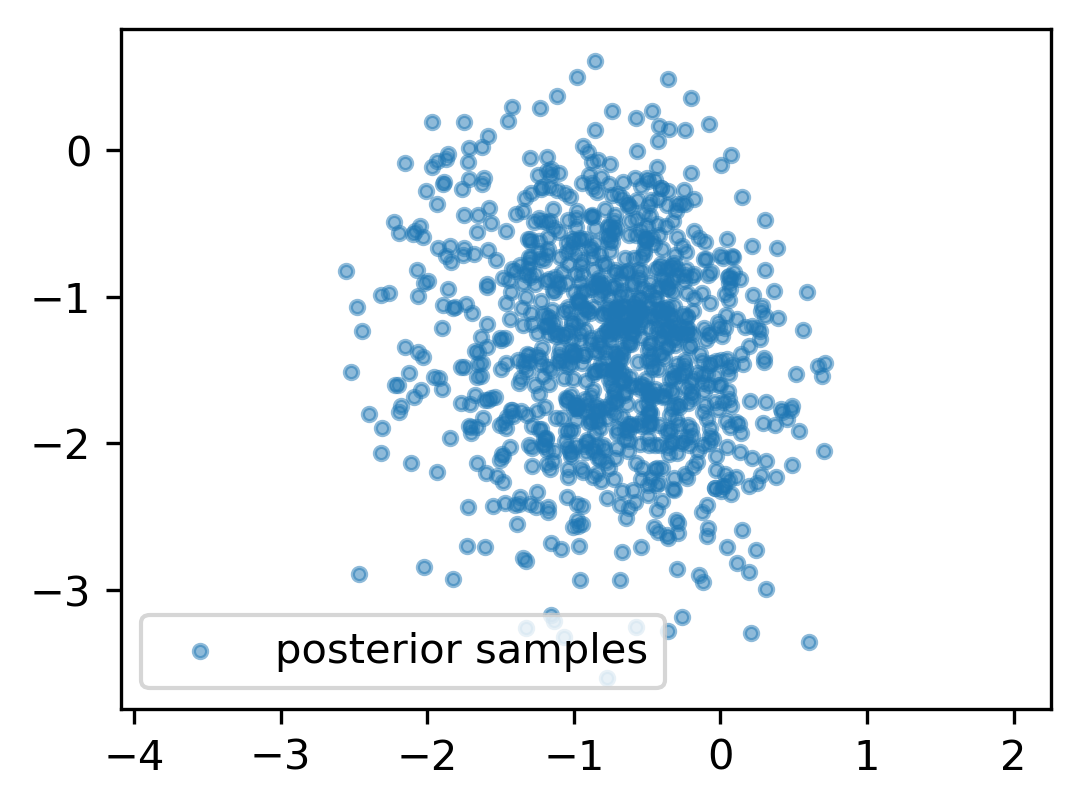

In [14]:
samples = np.array(samples).squeeze()

plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(samples[:, 0], samples[:, 1], label='posterior samples', s=10, alpha=0.5)
plt.legend()
plt.axis('equal');

## Task 3

### EVALUATING THETA

In [6]:
### How to evaluate
### Distribution of Z latent space is invariant by any orthogonal transformation
### Compute the min of the norm of difference of theta_0 - Orthogonal * hat_theta
### Allow you to retrive the invariance of latent space wrt orthogonal transformation
def r_phi(phi):
    return np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi),np.cos(phi)]])

def r_phi_ref(phi):
    return np.array([[np.cos(phi), np.sin(phi)], [np.sin(phi), -np.cos(phi)]])

def eval(theta_0, hat_theta, n_phi):
    phis = np.linspace(0, 2* np.pi, n_phi)
    l = []
    ####Want to compute norm of theta_0 - R * hat_theta
    #### Any norm is good, svd or 
    for p in phis:
        #s = np.linalg.svd(theta_0.cpu().detach().numpy()- r_phi(p)@hat_theta.cpu().detach().numpy(), compute_uv = False)
        #s_ref = np.linalg.svd(theta_0.cpu().detach().numpy() - r_phi_ref(p)@hat_theta.cpu().detach().numpy(), compute_uv = False)
        #l.append(np.sum(s**2))
        #l.append(np.sum(s_ref**2))
        l.append(np.linalg.norm(theta_0.cpu().detach().numpy()- r_phi(p)@hat_theta.cpu().detach().numpy()))
        l.append(np.linalg.norm(theta_0.cpu().detach().numpy()- r_phi_ref(p)@hat_theta.cpu().detach().numpy()))
    return min(l)



6.3329787


#### Fisher's identity, our HMC



In [17]:
num_epoches = 100
batch_size = 200


print_info_ = 5

K_wu = 70
K_s = 30
args.N = 2

dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

dec_our_hmc_fisher = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(params=dec_our_hmc_fisher.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max')

transitions = HMC_vanilla(args)



In [11]:

class Target():
    def __init__(self,):
        pass
    def get_logdensity(self, z, x):
        probs = torch.sigmoid(dec_our_hmc_fisher(z))
        return torch.distributions.Bernoulli(probs=probs).log_prob(x).sum(1) + std_normal.log_prob(z).sum(1)
target = Target()


In [71]:

for ep in tqdm(range(num_epoches)): # cycle over epoches
    j = 0
    obj_sum = 0
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        
        momentum = std_normal.sample((batch_train.shape[0], z_dim))
        z = std_normal.sample((batch_train.shape[0], z_dim))

#         pdb.set_trace()
        for _ in range(K_wu):
            z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=batch_train)
            
        obj = 0
        for _ in range(K_s):
            z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=batch_train)
            probs = torch.sigmoid(dec_our_hmc_fisher(z))
            obj += torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean()
            
        obj /= K_s 

        (-obj).backward()
        optimizer.step()
        optimizer.zero_grad()
        
        j += 1
        obj_sum += obj.cpu().detach().numpy()
    scheduler.step(obj)
    obj_sum /= j
    if ep % print_info_ == 0:
        print('obj mean over epoch:', obj_sum)
        print('obj:', obj.cpu().detach().item())
        print('true diff to theta: ', eval(true_theta, dec_our_hmc_fisher.W.weight.T, 200))




  1%|          | 1/100 [00:19<31:47, 19.26s/it]

obj mean over epoch: -0.6774089550971985
obj: -0.6786472797393799
true diff to theta:  34.90882365460733


  6%|▌         | 6/100 [01:54<29:38, 18.92s/it]

obj mean over epoch: -0.645768494606018
obj: -0.639400064945221
true diff to theta:  24.158165822244133


 11%|█         | 11/100 [03:42<32:06, 21.65s/it]

obj mean over epoch: -0.614772355556488
obj: -0.6105393171310425
true diff to theta:  15.686047715331533


 16%|█▌        | 16/100 [05:27<29:08, 20.81s/it]

obj mean over epoch: -0.5907112038135529
obj: -0.580992579460144
true diff to theta:  9.882463714211653


 21%|██        | 21/100 [07:08<27:37, 20.98s/it]

obj mean over epoch: -0.5774281263351441
obj: -0.5613259077072144
true diff to theta:  6.547752373875408


 26%|██▌       | 26/100 [08:47<24:27, 19.84s/it]

obj mean over epoch: -0.5703528606891632
obj: -0.5953282117843628
true diff to theta:  4.53198022479597


 26%|██▌       | 26/100 [09:03<25:46, 20.90s/it]


KeyboardInterrupt: 

In [ ]:
print('true_theta', true_theta)
print('-' * 100)
print(dec_our_hmc_fisher.W.weight.detach().T)

for p in dec_our_hmc_fisher.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec_our_hmc_fisher(u)))
print('true probs', torch.sigmoid(u @ true_theta))



### Encoder with true fixed theta



In [12]:

K = 16
enc_0 = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)

optimizer_phi = torch.optim.Adam(params=enc_0.parameters(), lr=1e-3)
true_kl = False
batch_size = 100
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)


In [ ]:

print_info = 500
for ep in tqdm(range(num_epoches)):
    elbo_ep = 0
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        mu, sigma = enc_0(batch_train)
        u = std_normal.sample(mu.shape)
        z = mu + sigma * u # reparametrization trick
        probs = torch.sigmoid(z @ true_theta)
        if true_kl == True:
            log_likelihood = torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).sum(1)
            KLD = (-0.5 * (1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))).sum(1)
            elbo = (log_likelihood - KLD).mean()    
        else:    
            log_p = torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).sum(1) + std_normal.log_prob(z).sum(1)
            sum_log_sigma = torch.sum(torch.log(sigma), 1)
            log_m = std_normal.log_prob(u).sum(1) - sum_log_sigma
            elbo = (log_p - log_m).mean()
        elbo_ep += elbo.detach().cpu().numpy()
        (-elbo).backward()
        optimizer_phi.step()
        optimizer_phi.zero_grad()
    if ep % print_info ==0:
        print('elbo: ', (elbo_ep / b_num))

for p in enc_0.parameters():
    p.requires_grad_(False)



Convergence seems to appear after 10 epoches only, for lr = 1e-3 and batch_size = 500 and 5 epoches for batch_size = 100 and lr = 1e-3



In [ ]:
n_warmup = 50
n_samples = 500

data_ind = 1  #  index of datapoint we conditioned on
def potential_fn(z):
    z = z['points']
    probs = torch.sigmoid(z @ true_theta)
    return -torch.sum(pyro.distributions.Bernoulli(probs=probs).log_prob(data[data_ind][None]).sum(1) + std_normal_pyro.log_prob(z).sum(1))


In [ ]:
init_samples = std_normal_pyro.sample((1, z_dim))
init_params = {'points': init_samples}

nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel,
            initial_params=init_params,
            num_samples=n_samples,
            warmup_steps=n_warmup)

mcmc.run()
z = mcmc.get_samples()['points'].squeeze()

mu, sigma = enc_0(data[data_ind][None])
u_enc = std_normal_pyro.sample((n_samples, z_dim))
z_enc = mu + sigma * u_enc
z_enc = z_enc.detach()




Plotting the two distributions for observations $\mathrm{data\_ind}$ and checking that variational approximation is good


In [ ]:
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), label='posterior samples', s=10, alpha=0.1)
plt.scatter(z_enc[:, 0].cpu(), z_enc[:, 1].cpu(), label='encoder samples', s=10, alpha=0.1, color = 'red')
plt.legend()
plt.axis('equal');



### lagging VAE 

Encoder seems to reach convergence within 5 epoches with lr_phi = 1e-3 and batch size = 100



In [13]:

K = 10
enc_lagg = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec_lagg = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

optimizer_phi = torch.optim.Adam(params=enc_lagg.parameters(), lr = 1e-3)
optimizer_theta = torch.optim.Adam(params=dec_lagg.parameters(), lr = 1e-3)
n_epoches_enc = 5
true_kl = False
better_log = False
batch_size = 500
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)




In [75]:
print_info = 10
count = 0
num_epoches=1000
for ep in tqdm(range(num_epoches)):
    elbo_ep = 0
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        mu, sigma = enc_lagg(batch_train)
        u = std_normal.sample(mu.shape)
        z = mu + sigma * u # reparametrization trick
        prod = (dec_lagg(z))
        if true_kl == True:
            if better_log == True:
                log_likelihood = (batch_train * dec_lagg(mu) - torch.log(1 + torch.exp(prod))).sum(1)
            else:
                log_likelihood = torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_train).sum(1)
            KLD = (-0.5 * (1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))).sum(1)
            elbo = (log_likelihood - KLD).mean()    
        else:    
            log_p = torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_train).sum(1) + std_normal.log_prob(z).sum(1)
            sum_log_sigma = torch.sum(torch.log(sigma), 1)
            log_m = std_normal.log_prob(u).sum(1) - sum_log_sigma
            elbo = (log_p - log_m).mean()
        elbo_ep += elbo
        (-elbo).backward()
        if ep % n_epoches_enc == 0:
            optimizer_theta.step()
            optimizer_phi.zero_grad()
            optimizer_theta.zero_grad()
        else:
            optimizer_phi.step()
            optimizer_phi.zero_grad()
            optimizer_theta.zero_grad()
    if ep % n_epoches_enc==0:
        count += 1
    if (ep % print_info==0):
        print('Epoch_theta ', count)
        print('elbo: ', (elbo_ep / b_num).cpu().detach().numpy())
        print('true diff to theta: ', eval(true_theta, dec_lagg.W.weight.T, 200))
        if False:
            init_samples = std_normal_pyro.sample((1, z_dim))
            init_params = {'points': init_samples}
            nuts_kernel = NUTS(potential_fn=potential_fn)
            def potential_fn(z):
                z = z['points']
                probs = torch.sigmoid(dec_lagg(z))
                return -torch.sum(pyro.distributions.Bernoulli(probs=probs).log_prob(data[data_ind][None]).sum(1) + std_normal_pyro.log_prob(z).sum(1))
            mcmc = MCMC(nuts_kernel,
                        initial_params=init_params,
                        num_samples=n_samples,
                        warmup_steps=n_warmup)
            mcmc.run()
            z = mcmc.get_samples()['points'].squeeze()
            mu, sigma = enc_lagg(data[data_ind][None])
            u_enc = std_normal_pyro.sample((n_samples, z_dim))
            z_enc = mu + sigma * u_enc
            z_enc = z_enc.detach()
            plt.figure(figsize=(4, 3), dpi=300)
            plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), label='posterior samples', s=10, alpha=0.1)
            plt.scatter(z_enc[:, 0].cpu(), z_enc[:, 1].cpu(), label='encoder samples', s=10, alpha=0.1, color='red')
            plt.legend()
            plt.axis('equal')
            plt.show()
        #print('KL divergence: ', KLD.mean().cpu().detach().numpy())

print('true_theta', true_theta)
print('-' * 100)
print(dec_lagg.W.weight.detach().T)



  0%|          | 2/1000 [00:00<02:40,  6.21it/s]

Epoch_theta  1
elbo:  -15.520937
true diff to theta:  6.361342741288113


  1%|          | 12/1000 [00:01<02:35,  6.35it/s]

Epoch_theta  3
elbo:  -14.868587
true diff to theta:  6.291144228178771


  2%|▏         | 22/1000 [00:03<02:32,  6.42it/s]

Epoch_theta  5
elbo:  -14.771838
true diff to theta:  6.197454199309844


  3%|▎         | 32/1000 [00:04<02:30,  6.44it/s]

Epoch_theta  7
elbo:  -14.720975
true diff to theta:  6.0964254355990715


  4%|▍         | 42/1000 [00:06<02:28,  6.47it/s]

Epoch_theta  9
elbo:  -14.666816
true diff to theta:  5.985255875153743


  5%|▌         | 52/1000 [00:08<02:26,  6.47it/s]

Epoch_theta  11
elbo:  -14.605344
true diff to theta:  5.8542777173083


  6%|▌         | 61/1000 [00:09<02:33,  6.11it/s]

Epoch_theta  13
elbo:  -14.528902
true diff to theta:  5.71779026074533


  7%|▋         | 72/1000 [00:11<02:27,  6.30it/s]

Epoch_theta  15
elbo:  -14.449909
true diff to theta:  5.576670948030917


  7%|▋         | 74/1000 [00:11<02:24,  6.39it/s]


KeyboardInterrupt: 

### Vanilla VAE


In [8]:
K=10
enc_vae = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec_vae = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

optimizer_phi = torch.optim.Adam(params=enc_vae.parameters(), lr = 1e-3)
optimizer_theta = torch.optim.Adam(params=dec_vae.parameters(), lr = 5e-4)
true_kl = False
better_log = False
first_phi = 10
batch_size = 500
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)



In [9]:
print_info = 10
count = 0
num_epoches = 1000
for ep in tqdm(range(num_epoches)):
    elbo_ep = 0
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        mu, sigma = enc_vae(batch_train)
        u = std_normal.sample(mu.shape)
        z = mu + sigma * u # reparametrization trick
        prod = (dec_vae(z))
        if true_kl == True:
            if better_log == True:
                log_likelihood = (batch_train * dec_vae(mu) - torch.log(1 + torch.exp(prod))).sum(1)
            else:
                log_likelihood = torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_train).sum(1)
            KLD = (-0.5 * (1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))).sum(1)
            elbo = (log_likelihood - KLD).mean()    
        else:    
            log_p = torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_train).sum(1) + std_normal.log_prob(z).sum(1)
            sum_log_sigma = torch.sum(torch.log(sigma), 1)
            log_m = std_normal.log_prob(u).sum(1) - sum_log_sigma
            elbo = (log_p - log_m).mean()
        elbo_ep += elbo
        (-elbo).backward()
        if ep < first_phi:
            optimizer_phi.step()
            optimizer_phi.zero_grad()
            optimizer_theta.zero_grad()
        else:
            optimizer_theta.step()
            optimizer_phi.step()
            optimizer_phi.zero_grad()
            optimizer_theta.zero_grad()
    if (ep % print_info==0):
        print('Epoch ', ep)
        print('elbo: ', (elbo_ep / b_num).cpu().detach().numpy())
        print('true diff to theta: ', eval(true_theta, dec_vae.W.weight.T, 200))
        if False:
            init_samples = std_normal_pyro.sample((1, z_dim))
            init_params = {'points': init_samples}
            nuts_kernel = NUTS(potential_fn=potential_fn)
            def potential_fn(z):
                z = z['points']
                probs = torch.sigmoid(dec_vae(z))
                return -torch.sum(pyro.distributions.Bernoulli(probs=probs).log_prob(data[data_ind][None]).sum(1) + std_normal_pyro.log_prob(z).sum(1))
            mcmc = MCMC(nuts_kernel,
                        initial_params=init_params,
                        num_samples=n_samples,
                        warmup_steps=n_warmup)
            mcmc.run()
            z = mcmc.get_samples()['points'].squeeze()
            mu, sigma = enc_vae(data[data_ind][None])
            u_enc = std_normal_pyro.sample((n_samples, z_dim))
            z_enc = mu + sigma * u_enc
            z_enc = z_enc.detach()
            plt.figure(figsize=(4, 3), dpi=300)
            plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), label='posterior samples', s=10, alpha=0.1)
            plt.scatter(z_enc[:, 0].cpu(), z_enc[:, 1].cpu(), label='encoder samples', s=10, alpha=0.1, color='red')
            plt.legend()
            plt.axis('equal')
            plt.show()

print('true_theta', true_theta)
print('-' * 100)
print(dec_vanilla_vae.W.weight.detach().T)

for p in dec_vanilla_vae.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec_vanilla_vae(u)))
print('true probs', torch.sigmoid(u @ true_theta))


  0%|          | 3/1000 [00:00<01:50,  9.00it/s]

Epoch  0
elbo:  -7.894319
true diff to theta:  4.1493721226300515


  1%|          | 12/1000 [00:01<01:43,  9.59it/s]

Epoch  10
elbo:  -7.432446
true diff to theta:  4.129230424641086


  2%|▏         | 21/1000 [00:02<01:39,  9.88it/s]

Epoch  20
elbo:  -7.352821
true diff to theta:  3.948767472738874


  3%|▎         | 31/1000 [00:03<01:37,  9.90it/s]

Epoch  30
elbo:  -7.306662
true diff to theta:  3.757285423343091


  4%|▍         | 43/1000 [00:04<01:32, 10.40it/s]

Epoch  40
elbo:  -7.2630897
true diff to theta:  3.557800548208484


  5%|▌         | 51/1000 [00:05<01:34, 10.06it/s]

Epoch  50
elbo:  -7.223514
true diff to theta:  3.369231379403881


  6%|▌         | 62/1000 [00:06<01:38,  9.54it/s]

Epoch  60
elbo:  -7.186137
true diff to theta:  3.1901325667481735


  7%|▋         | 71/1000 [00:07<01:35,  9.77it/s]

Epoch  70
elbo:  -7.161093
true diff to theta:  3.0348342698916775


  8%|▊         | 83/1000 [00:08<01:29, 10.24it/s]

Epoch  80
elbo:  -7.1391945
true diff to theta:  2.879069139056834


  9%|▉         | 91/1000 [00:09<01:31,  9.98it/s]

Epoch  90
elbo:  -7.1230154
true diff to theta:  2.718458738323387


 10%|█         | 101/1000 [00:10<01:29, 10.09it/s]

Epoch  100
elbo:  -7.110247
true diff to theta:  2.552144774913212


 11%|█         | 111/1000 [00:10<01:29,  9.96it/s]

Epoch  110
elbo:  -7.091271
true diff to theta:  2.372647463172586


 12%|█▏        | 121/1000 [00:11<01:27, 10.08it/s]

Epoch  120
elbo:  -7.0757318
true diff to theta:  2.1958699967486006


 13%|█▎        | 133/1000 [00:13<01:25, 10.17it/s]

Epoch  130
elbo:  -7.062978
true diff to theta:  2.0209881273624384


 14%|█▍        | 143/1000 [00:14<01:18, 10.89it/s]

Epoch  140
elbo:  -7.0481753
true diff to theta:  1.8577483046010586


 15%|█▌        | 153/1000 [00:14<01:17, 10.98it/s]

Epoch  150
elbo:  -7.0368867
true diff to theta:  1.7065778406458487


 16%|█▋        | 163/1000 [00:15<01:15, 11.03it/s]

Epoch  160
elbo:  -7.0292616
true diff to theta:  1.575280044512531


 17%|█▋        | 173/1000 [00:16<01:14, 11.05it/s]

Epoch  170
elbo:  -7.023525
true diff to theta:  1.4556153649859687


 18%|█▊        | 183/1000 [00:17<01:14, 11.01it/s]

Epoch  180
elbo:  -7.018921
true diff to theta:  1.35432319683168


 19%|█▉        | 193/1000 [00:18<01:13, 11.01it/s]

Epoch  190
elbo:  -7.0137763
true diff to theta:  1.2672764182903207


 20%|██        | 203/1000 [00:19<01:12, 10.97it/s]

Epoch  200
elbo:  -7.0116696
true diff to theta:  1.1937128609164767


 21%|██▏       | 213/1000 [00:20<01:11, 11.02it/s]

Epoch  210
elbo:  -7.011146
true diff to theta:  1.1296922126508313


 22%|██▏       | 223/1000 [00:21<01:10, 10.95it/s]

Epoch  220
elbo:  -7.0099545
true diff to theta:  1.073878615707634


 23%|██▎       | 233/1000 [00:22<01:09, 11.05it/s]

Epoch  230
elbo:  -7.0051503
true diff to theta:  1.024855797481874


 24%|██▍       | 241/1000 [00:22<01:11, 10.65it/s]

Epoch  240
elbo:  -7.0051165
true diff to theta:  0.9824262762204568


 25%|██▌       | 253/1000 [00:24<01:08, 10.86it/s]

Epoch  250
elbo:  -7.0043817
true diff to theta:  0.9481255116381736


 26%|██▋       | 263/1000 [00:25<01:08, 10.76it/s]

Epoch  260
elbo:  -7.0071363
true diff to theta:  0.9179196765805885


 27%|██▋       | 271/1000 [00:25<01:10, 10.32it/s]

Epoch  270
elbo:  -7.004233
true diff to theta:  0.890826041998277


 28%|██▊       | 283/1000 [00:26<01:07, 10.59it/s]

Epoch  280
elbo:  -7.0067196
true diff to theta:  0.8643889918938491


 29%|██▉       | 293/1000 [00:27<01:06, 10.61it/s]

Epoch  290
elbo:  -7.006531
true diff to theta:  0.8451954747031822


 30%|███       | 301/1000 [00:28<01:08, 10.18it/s]

Epoch  300
elbo:  -7.0062327
true diff to theta:  0.8313520398807174


 31%|███▏      | 313/1000 [00:29<01:06, 10.40it/s]

Epoch  310
elbo:  -7.0039825
true diff to theta:  0.8131833663160872


 32%|███▏      | 321/1000 [00:30<01:04, 10.48it/s]

Epoch  320
elbo:  -7.006654
true diff to theta:  0.7978233949202244


 33%|███▎      | 333/1000 [00:31<01:01, 10.77it/s]

Epoch  330
elbo:  -7.006268
true diff to theta:  0.7843253753353464


 34%|███▍      | 343/1000 [00:32<01:00, 10.89it/s]

Epoch  340
elbo:  -7.0048394
true diff to theta:  0.7728929848729652


 35%|███▌      | 353/1000 [00:33<00:59, 10.82it/s]

Epoch  350
elbo:  -7.005094
true diff to theta:  0.759494416610997


 36%|███▋      | 363/1000 [00:34<00:59, 10.78it/s]

Epoch  360
elbo:  -7.0035706
true diff to theta:  0.7505402290911253


 37%|███▋      | 373/1000 [00:35<00:58, 10.72it/s]

Epoch  370
elbo:  -7.002472
true diff to theta:  0.7454203050470198


 38%|███▊      | 383/1000 [00:36<00:58, 10.63it/s]

Epoch  380
elbo:  -7.004282
true diff to theta:  0.7342397624756343


 39%|███▉      | 393/1000 [00:37<00:57, 10.61it/s]

Epoch  390
elbo:  -7.00533
true diff to theta:  0.7290503998812184


 40%|████      | 403/1000 [00:38<00:54, 10.93it/s]

Epoch  400
elbo:  -7.0048337
true diff to theta:  0.7212480404665592


 41%|████▏     | 413/1000 [00:39<00:53, 10.92it/s]

Epoch  410
elbo:  -7.0022745
true diff to theta:  0.7148329227611401


 42%|████▏     | 423/1000 [00:39<00:52, 10.92it/s]

Epoch  420
elbo:  -7.0031424
true diff to theta:  0.7110073051862492


 43%|████▎     | 433/1000 [00:40<00:53, 10.62it/s]

Epoch  430
elbo:  -7.0038934
true diff to theta:  0.7043813972808101


 44%|████▍     | 443/1000 [00:41<00:52, 10.57it/s]

Epoch  440
elbo:  -7.0017757
true diff to theta:  0.6985036629240441


 45%|████▌     | 453/1000 [00:42<00:51, 10.67it/s]

Epoch  450
elbo:  -7.002183
true diff to theta:  0.6944161026151746


 46%|████▋     | 463/1000 [00:43<00:50, 10.66it/s]

Epoch  460
elbo:  -7.0033007
true diff to theta:  0.6909425030088236


 47%|████▋     | 471/1000 [00:44<00:51, 10.20it/s]

Epoch  470
elbo:  -7.002959
true diff to theta:  0.6867406550616498


 48%|████▊     | 481/1000 [00:45<00:50, 10.31it/s]

Epoch  480
elbo:  -7.0021396
true diff to theta:  0.6819201951289897


 49%|████▉     | 493/1000 [00:46<00:47, 10.75it/s]

Epoch  490
elbo:  -7.0016866
true diff to theta:  0.6767501312831974


 50%|█████     | 501/1000 [00:47<00:46, 10.69it/s]

Epoch  500
elbo:  -7.0041127
true diff to theta:  0.6772465811847996


 51%|█████     | 512/1000 [00:48<00:51,  9.51it/s]

Epoch  510
elbo:  -7.0027127
true diff to theta:  0.66911980289084


 52%|█████▏    | 523/1000 [00:49<00:48,  9.78it/s]

Epoch  520
elbo:  -7.0020204
true diff to theta:  0.6680413749051899


 53%|█████▎    | 532/1000 [00:50<00:47,  9.81it/s]

Epoch  530
elbo:  -7.003356
true diff to theta:  0.6686238778061588


 54%|█████▍    | 542/1000 [00:51<00:45, 10.09it/s]

Epoch  540
elbo:  -7.0029182
true diff to theta:  0.6640410895968172


 55%|█████▌    | 552/1000 [00:52<00:43, 10.33it/s]

Epoch  550
elbo:  -7.0030823
true diff to theta:  0.6592788390203919


 56%|█████▌    | 562/1000 [00:53<00:42, 10.22it/s]

Epoch  560
elbo:  -7.001764
true diff to theta:  0.6588351572958019


 57%|█████▋    | 572/1000 [00:54<00:40, 10.65it/s]

Epoch  570
elbo:  -7.002419
true diff to theta:  0.6586671308599741


 58%|█████▊    | 582/1000 [00:55<00:38, 10.80it/s]

Epoch  580
elbo:  -7.0040765
true diff to theta:  0.6582361564816488


 59%|█████▉    | 592/1000 [00:56<00:37, 10.82it/s]

Epoch  590
elbo:  -7.003451
true diff to theta:  0.6596014321665636


 60%|██████    | 602/1000 [00:57<00:36, 10.94it/s]

Epoch  600
elbo:  -6.999542
true diff to theta:  0.6577891876188616


 61%|██████    | 612/1000 [00:57<00:35, 10.91it/s]

Epoch  610
elbo:  -7.0018945
true diff to theta:  0.6520993670384824


 62%|██████▏   | 622/1000 [00:58<00:34, 10.96it/s]

Epoch  620
elbo:  -7.001298
true diff to theta:  0.6515680640967654


 63%|██████▎   | 632/1000 [00:59<00:33, 10.89it/s]

Epoch  630
elbo:  -7.0019803
true diff to theta:  0.654967998063317


 64%|██████▍   | 642/1000 [01:00<00:33, 10.73it/s]

Epoch  640
elbo:  -7.001059
true diff to theta:  0.6503071174304783


 65%|██████▌   | 652/1000 [01:01<00:31, 10.89it/s]

Epoch  650
elbo:  -7.001407
true diff to theta:  0.6476674886782424


 66%|██████▌   | 662/1000 [01:02<00:30, 10.97it/s]

Epoch  660
elbo:  -7.001593
true diff to theta:  0.6490758918775668


 67%|██████▋   | 672/1000 [01:03<00:30, 10.92it/s]

Epoch  670
elbo:  -7.0031753
true diff to theta:  0.6479989774222484


 68%|██████▊   | 682/1000 [01:04<00:29, 10.90it/s]

Epoch  680
elbo:  -7.001695
true diff to theta:  0.6446531122265856


 69%|██████▉   | 692/1000 [01:05<00:28, 10.91it/s]

Epoch  690
elbo:  -7.00335
true diff to theta:  0.6491921926294157


 70%|███████   | 702/1000 [01:06<00:27, 10.91it/s]

Epoch  700
elbo:  -7.001244
true diff to theta:  0.6432428766211223


 71%|███████   | 712/1000 [01:06<00:26, 10.88it/s]

Epoch  710
elbo:  -7.001522
true diff to theta:  0.6443614642815174


 72%|███████▏  | 722/1000 [01:07<00:25, 10.88it/s]

Epoch  720
elbo:  -7.002323
true diff to theta:  0.6439024266078117


 73%|███████▎  | 732/1000 [01:08<00:24, 10.88it/s]

Epoch  730
elbo:  -7.000979
true diff to theta:  0.6411054128930117


 74%|███████▍  | 742/1000 [01:09<00:23, 10.90it/s]

Epoch  740
elbo:  -7.002311
true diff to theta:  0.6398279767966124


 75%|███████▌  | 752/1000 [01:10<00:22, 10.94it/s]

Epoch  750
elbo:  -7.000696
true diff to theta:  0.6433677303234834


 76%|███████▌  | 762/1000 [01:11<00:21, 10.82it/s]

Epoch  760
elbo:  -7.0012603
true diff to theta:  0.6429753439298858


 77%|███████▋  | 772/1000 [01:12<00:20, 10.90it/s]

Epoch  770
elbo:  -7.0016246
true diff to theta:  0.640272647811081


 78%|███████▊  | 782/1000 [01:13<00:20, 10.88it/s]

Epoch  780
elbo:  -7.001465
true diff to theta:  0.6425304373893908


 79%|███████▉  | 792/1000 [01:14<00:19, 10.92it/s]

Epoch  790
elbo:  -7.0014615
true diff to theta:  0.6427827596467801


 80%|████████  | 802/1000 [01:15<00:18, 10.98it/s]

Epoch  800
elbo:  -6.9997053
true diff to theta:  0.6464437330409638


 81%|████████  | 812/1000 [01:16<00:17, 11.01it/s]

Epoch  810
elbo:  -6.9998283
true diff to theta:  0.643598654296422


 82%|████████▏ | 822/1000 [01:16<00:16, 10.98it/s]

Epoch  820
elbo:  -7.000815
true diff to theta:  0.6463034940980119


 83%|████████▎ | 832/1000 [01:17<00:15, 10.94it/s]

Epoch  830
elbo:  -7.002366
true diff to theta:  0.6449082387117039


 84%|████████▍ | 842/1000 [01:18<00:14, 10.97it/s]

Epoch  840
elbo:  -7.00062
true diff to theta:  0.6457859231343677


 85%|████████▌ | 852/1000 [01:19<00:13, 10.98it/s]

Epoch  850
elbo:  -7.000357
true diff to theta:  0.6407160540288686


 86%|████████▌ | 862/1000 [01:20<00:12, 10.93it/s]

Epoch  860
elbo:  -7.0021596
true diff to theta:  0.64307467795758


 87%|████████▋ | 872/1000 [01:21<00:11, 10.92it/s]

Epoch  870
elbo:  -7.000884
true diff to theta:  0.6394571997168488


 88%|████████▊ | 882/1000 [01:22<00:10, 10.96it/s]

Epoch  880
elbo:  -7.0035515
true diff to theta:  0.6403232260487545


 89%|████████▉ | 892/1000 [01:23<00:09, 10.88it/s]

Epoch  890
elbo:  -6.998555
true diff to theta:  0.6435688160415065


 90%|█████████ | 902/1000 [01:24<00:09, 10.68it/s]

Epoch  900
elbo:  -7.000453
true diff to theta:  0.6455372743019223


 91%|█████████ | 912/1000 [01:25<00:08, 10.55it/s]

Epoch  910
elbo:  -7.000627
true diff to theta:  0.6397835799530699


 92%|█████████▏| 922/1000 [01:26<00:07, 10.68it/s]

Epoch  920
elbo:  -7.0014687
true diff to theta:  0.6423996995269387


 93%|█████████▎| 932/1000 [01:26<00:06, 10.88it/s]

Epoch  930
elbo:  -7.002005
true diff to theta:  0.6402307211382776


 94%|█████████▍| 942/1000 [01:27<00:05, 10.94it/s]

Epoch  940
elbo:  -7.0013156
true diff to theta:  0.642762281913206


 95%|█████████▌| 952/1000 [01:28<00:04, 10.97it/s]

Epoch  950
elbo:  -6.998384
true diff to theta:  0.6405966509794723


 96%|█████████▌| 962/1000 [01:29<00:03, 10.92it/s]

Epoch  960
elbo:  -7.0008707
true diff to theta:  0.6405353044932632


 97%|█████████▋| 972/1000 [01:30<00:02, 10.84it/s]

Epoch  970
elbo:  -7.000318
true diff to theta:  0.6448875167025088


 98%|█████████▊| 982/1000 [01:31<00:01, 10.84it/s]

Epoch  980
elbo:  -7.001836
true diff to theta:  0.6392167704898349


 99%|█████████▉| 992/1000 [01:32<00:00, 10.94it/s]

Epoch  990
elbo:  -7.001081
true diff to theta:  0.639015092444518


100%|██████████| 1000/1000 [01:33<00:00, 10.75it/s]

true_theta tensor([[-1.5256, -0.7502, -0.6540, -1.6095,  0.8657,  0.2444, -0.6629,  0.8073,
          0.4391,  1.1712],
        [ 1.7674, -0.0954,  0.0612, -0.6177, -0.7981, -0.1316, -0.7984,  0.3357,
          0.2753,  1.7163]])
----------------------------------------------------------------------------------------------------


NameError: name 'dec_vanilla_vae' is not defined

## Task 4

### Selecting best annealing coeff

In [17]:
K = 8
num_epoches = 3000
batch_size = 200
print_info_ = 500

dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True)

enc = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec_annealing_all = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

params = list(enc.parameters()) + list(dec_annealing_all.parameters())
optimizer = torch.optim.Adam(params=params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max', patience=150, factor=0.75)

In [18]:
def run_validation(enc, dec):
    for p in enc.parameters():
        p.requires_grad_(False)
        
    for p in dec.parameters():
        p.requires_grad_(False)
        
    j = 0
    elbo_sum = 0
    for b_num, batch_val in enumerate(dataloader_val):
        mu, sigma = enc(batch_val) # sample mu and sigma from encoder
        u = std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + u * sigma # reperametrization trick

        prod = dec(z)
        log_likelihood = torch.mean(torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_val))

        KLD = -0.5 * torch.mean(1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))
        elbo = log_likelihood - KLD
        
        j += 1
        elbo_sum += elbo.cpu().detach().numpy()
        
    elbo_sum /= j
    for p in enc.parameters():
        p.requires_grad_(True)
        
    for p in dec.parameters():
        p.requires_grad_(True)
    return elbo_sum

In [19]:
def run_training(enc, dec, best_beta=None, annealing_beta=True):
    patience = 100
    patience_current = 0
    
    if annealing_beta:
        beta = torch.linspace(0., 1., 20, device=device)
        beta_ind = 0
        beta_current = beta[beta_ind]
        best_ind = 0
    else:
        beta_current = 1.

    best_elbo = -float('inf')
    iterator = tqdm(range(num_epoches))

    for ep in iterator: # cycle over epoches
        j = 0
        elbo_sum = 0
        for b_num, batch_train in enumerate(dataloader): # cycle over batches
            mu, sigma = enc(batch_train) # sample mu and sigma from encoder
            u = std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
            z = mu + u * sigma # reperametrization trick

            prod = dec(z)
#             log_likelihood = torch.mean(torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_train))
            log_likelihood = (batch_train * dec(mu) - torch.log(1 + torch.exp(prod))).sum(1)

            KLD = beta_current * (-0.5) * torch.sum(1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2), 1)
            elbo = torch.mean(log_likelihood - KLD)
            
            (-elbo).backward()

            optimizer.step()
            optimizer.zero_grad()

            j += 1
            elbo_sum += elbo.cpu().detach().numpy()

        current_val_elbo = run_validation(enc, dec)
        elbo_sum /= j

        if current_val_elbo > best_elbo:
            patience_current = 0
            best_elbo = current_val_elbo
            if annealing_beta:
                best_ind = beta_ind
        else:
            patience_current += 1
            if patience_current >= patience:
                if annealing_beta:
                    beta_ind = min(beta_ind + 1, beta.shape[0] - 1)
                    if best_beta:
                        beta_current = min(beta[beta_ind], best_beta)
                    else:
                        beta_current = beta[beta_ind]
                    patience_current = 0
                    print('Current beta:', beta_current)
                else:
                    iterator.close()
                    break

    #     scheduler.step(elbo_sum)
        if ep % print_info_ == 0:
            print('Current validational ELBO:', current_val_elbo)
            if annealing_beta:
                print('Current best validational ELBO:', best_elbo, 'index:', best_ind)
            else:
                print('Current best validational ELBO:', best_elbo)
            print('elbo mean over epoch:', elbo_sum)
            print('elbo:', elbo.cpu().detach().numpy())
            print('likelihood', log_likelihood.cpu().mean().detach().numpy())
            print('KLD', KLD.cpu().mean().detach().numpy())
    if annealing_beta and (best_beta is None):
        print('Finish')
        print('Best beta', beta[best_ind])
        return beta[best_ind]

In [20]:
best_beta = run_training(enc, dec_annealing_all)

  0%|          | 2/3000 [00:00<07:42,  6.48it/s]

Current validational ELBO: -0.7893006682395936
Current best validational ELBO: -0.7893006682395936 index: 0
elbo mean over epoch: -7.3495682334899906
elbo: -7.305869
likelihood -7.305869
KLD 0.0


  3%|▎         | 102/3000 [00:13<06:31,  7.39it/s]

Current beta: tensor(0.0526, device='cuda:0')


  7%|▋         | 202/3000 [00:27<06:18,  7.39it/s]

Current beta: tensor(0.1053, device='cuda:0')


 10%|█         | 302/3000 [00:40<06:09,  7.31it/s]

Current beta: tensor(0.1579, device='cuda:0')


 13%|█▎        | 402/3000 [00:54<05:57,  7.26it/s]

Current beta: tensor(0.2105, device='cuda:0')


 17%|█▋        | 502/3000 [01:08<05:41,  7.32it/s]

Current beta: tensor(0.2632, device='cuda:0')
Current validational ELBO: -1.8769989252090453
Current best validational ELBO: -0.7893006682395936 index: 0
elbo mean over epoch: -4.92001745223999
elbo: -4.627346
likelihood -4.011404
KLD 0.6159412


 20%|██        | 602/3000 [01:21<05:21,  7.45it/s]

Current beta: tensor(0.3158, device='cuda:0')


 23%|██▎       | 702/3000 [01:35<05:15,  7.29it/s]

Current beta: tensor(0.3684, device='cuda:0')


 27%|██▋       | 802/3000 [01:49<04:56,  7.41it/s]

Current beta: tensor(0.4211, device='cuda:0')


 30%|███       | 902/3000 [02:02<04:47,  7.29it/s]

Current beta: tensor(0.4737, device='cuda:0')


 33%|███▎      | 1002/3000 [02:16<04:30,  7.39it/s]

Current beta: tensor(0.5263, device='cuda:0')
Current validational ELBO: -1.5024275302886962
Current best validational ELBO: -0.7893006682395936 index: 0
elbo mean over epoch: -5.574191007614136
elbo: -5.908444
likelihood -4.9098506
KLD 0.99859375


 37%|███▋      | 1102/3000 [02:29<04:19,  7.31it/s]

Current beta: tensor(0.5789, device='cuda:0')


 40%|████      | 1202/3000 [02:43<04:01,  7.45it/s]

Current beta: tensor(0.6316, device='cuda:0')


 43%|████▎     | 1302/3000 [02:57<03:53,  7.27it/s]

Current beta: tensor(0.6842, device='cuda:0')


 47%|████▋     | 1402/3000 [03:10<03:35,  7.41it/s]

Current beta: tensor(0.7368, device='cuda:0')


 50%|█████     | 1502/3000 [03:24<03:22,  7.40it/s]

Current beta: tensor(0.7895, device='cuda:0')
Current validational ELBO: -1.2775094985961915
Current best validational ELBO: -0.7893006682395936 index: 0
elbo mean over epoch: -5.942164478302002
elbo: -6.255864
likelihood -5.098993
KLD 1.1568706


 53%|█████▎    | 1602/3000 [03:37<03:07,  7.47it/s]

Current beta: tensor(0.8421, device='cuda:0')


 57%|█████▋    | 1702/3000 [03:51<02:56,  7.36it/s]

Current beta: tensor(0.8947, device='cuda:0')


 60%|██████    | 1802/3000 [04:04<02:43,  7.33it/s]

Current beta: tensor(0.9474, device='cuda:0')


 63%|██████▎   | 1902/3000 [04:18<02:28,  7.40it/s]

Current beta: tensor(1., device='cuda:0')


 67%|██████▋   | 2002/3000 [04:32<02:14,  7.42it/s]

Current beta: tensor(1., device='cuda:0')
Current validational ELBO: -1.0981261491775514
Current best validational ELBO: -0.7893006682395936 index: 0
elbo mean over epoch: -6.328453578948975
elbo: -6.5221996
likelihood -5.3564563
KLD 1.1657434


 70%|███████   | 2102/3000 [04:45<01:58,  7.56it/s]

Current beta: tensor(1., device='cuda:0')


 73%|███████▎  | 2202/3000 [04:58<01:48,  7.37it/s]

Current beta: tensor(1., device='cuda:0')


 77%|███████▋  | 2302/3000 [05:12<01:33,  7.48it/s]

Current beta: tensor(1., device='cuda:0')


 80%|████████  | 2402/3000 [05:25<01:19,  7.48it/s]

Current beta: tensor(1., device='cuda:0')


 83%|████████▎ | 2502/3000 [05:38<01:06,  7.48it/s]

Current beta: tensor(1., device='cuda:0')
Current validational ELBO: -1.0595893621444703
Current best validational ELBO: -0.7893006682395936 index: 0
elbo mean over epoch: -6.2388704395294186
elbo: -6.059628
likelihood -4.964479
KLD 1.0951488


 87%|████████▋ | 2602/3000 [05:52<00:54,  7.36it/s]

Current beta: tensor(1., device='cuda:0')


 90%|█████████ | 2702/3000 [06:06<00:40,  7.32it/s]

Current beta: tensor(1., device='cuda:0')


 93%|█████████▎| 2802/3000 [06:19<00:26,  7.36it/s]

Current beta: tensor(1., device='cuda:0')


 97%|█████████▋| 2902/3000 [06:33<00:13,  7.29it/s]

Current beta: tensor(1., device='cuda:0')


100%|██████████| 3000/3000 [06:46<00:00,  7.38it/s]

Finish
Best beta tensor(0., device='cuda:0')


In [21]:
print('true_theta', true_theta)
print('-' * 100)
print(dec_annealing_all.W.weight.detach().T)

true_theta tensor([[-0.2963,  2.6764, -0.1408, -0.8441,  0.2905, -0.2838, -1.4535,  2.3737,
         -0.0177, -2.7884],
        [-0.3788,  0.7046, -1.3956, -0.1248, -0.9259, -1.5463, -0.4902,  0.0244,
         -1.5992, -0.8469]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[ 0.3163,  0.2291,  1.2451, -0.1628,  0.9789,  1.3099, -0.0116,  0.7617,
          1.4595, -0.0604],
        [ 0.4007, -2.5592,  0.5494,  0.8392, -0.0241,  0.6852,  1.4899, -2.1309,
          0.4691,  2.5818]], device='cuda:0')


In [22]:
for p in dec_annealing_all.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec_annealing_all(u)))
print('true probs', torch.sigmoid(u @ true_theta))

reconstructed probs tensor([[0.4664, 0.6811, 0.4449, 0.4391, 0.4908, 0.4341, 0.3900, 0.6471, 0.4485,
         0.3158],
        [0.3132, 0.8174, 0.0875, 0.4123, 0.1806, 0.0728, 0.2567, 0.5880, 0.0678,
         0.1444],
        [0.6014, 0.3866, 0.7933, 0.5167, 0.7183, 0.8090, 0.5953, 0.5412, 0.8220,
         0.6525],
        [0.4381, 0.9262, 0.4995, 0.2960, 0.6064, 0.4740, 0.1944, 0.9125, 0.5409,
         0.0772],
        [0.3613, 0.9920, 0.4126, 0.1640, 0.6366, 0.3615, 0.0603, 0.9869, 0.4769,
         0.0083],
        [0.4000, 0.7093, 0.2371, 0.4437, 0.3254, 0.2186, 0.3518, 0.5773, 0.2147,
         0.2633],
        [0.3840, 0.8674, 0.2575, 0.3609, 0.3829, 0.2319, 0.2396, 0.7815, 0.2488,
         0.1212],
        [0.6766, 0.3726, 0.9259, 0.5019, 0.8601, 0.9368, 0.6296, 0.6526, 0.9476,
         0.6994],
        [0.4455, 0.9258, 0.5264, 0.2949, 0.6254, 0.5025, 0.1965, 0.9159, 0.5716,
         0.0786],
        [0.5685, 0.1624, 0.6040, 0.6302, 0.5094, 0.6256, 0.7234, 0.2084, 0.5944,
        

### Best annealing coeff

In [23]:
enc = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec_annealing_best = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

params = list(enc.parameters()) + list(dec_annealing_best.parameters())
optimizer = torch.optim.Adam(params=params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max', patience=150, factor=0.75)

In [24]:
run_training(enc, dec_annealing_best, best_beta)

  0%|          | 1/3000 [00:00<07:57,  6.28it/s]

Current validational ELBO: -0.975763463973999
Current best validational ELBO: -0.975763463973999 index: 0
elbo mean over epoch: -7.023444309234619
elbo: -7.0401573
likelihood -7.040157
KLD 0.0


  3%|▎         | 102/3000 [00:13<06:39,  7.25it/s]

Current beta: tensor(0.0526, device='cuda:0')


  7%|▋         | 202/3000 [00:27<06:23,  7.29it/s]

Current beta: tensor(0.1053, device='cuda:0')


 10%|█         | 302/3000 [00:41<06:06,  7.36it/s]

Current beta: tensor(0.1579, device='cuda:0')


 13%|█▎        | 402/3000 [00:54<05:52,  7.37it/s]

Current beta: tensor(0.2105, device='cuda:0')


 17%|█▋        | 502/3000 [01:08<05:41,  7.31it/s]

Current beta: tensor(0.2632, device='cuda:0')
Current validational ELBO: -1.8665243864059449
Current best validational ELBO: -0.975763463973999 index: 0
elbo mean over epoch: -4.968809680938721
elbo: -5.2543454
likelihood -4.659558
KLD 0.5947882


 20%|██        | 602/3000 [01:22<05:28,  7.29it/s]

Current beta: tensor(0.3158, device='cuda:0')


 23%|██▎       | 702/3000 [01:35<05:10,  7.40it/s]

Current beta: tensor(0.3684, device='cuda:0')


 27%|██▋       | 802/3000 [01:49<04:56,  7.42it/s]

Current beta: tensor(0.4211, device='cuda:0')


 30%|███       | 902/3000 [02:03<04:49,  7.26it/s]

Current beta: tensor(0.4737, device='cuda:0')


 33%|███▎      | 1002/3000 [02:16<04:32,  7.32it/s]

Current beta: tensor(0.5263, device='cuda:0')
Current validational ELBO: -1.4347455501556396
Current best validational ELBO: -0.975763463973999 index: 0
elbo mean over epoch: -5.49041750907898
elbo: -5.516172
likelihood -4.5971293
KLD 0.9190428


 37%|███▋      | 1102/3000 [02:30<04:14,  7.46it/s]

Current beta: tensor(0.5789, device='cuda:0')


 40%|████      | 1202/3000 [02:43<04:00,  7.47it/s]

Current beta: tensor(0.6316, device='cuda:0')


 43%|████▎     | 1302/3000 [02:57<03:50,  7.36it/s]

Current beta: tensor(0.6842, device='cuda:0')


 47%|████▋     | 1402/3000 [03:10<03:36,  7.37it/s]

Current beta: tensor(0.7368, device='cuda:0')


 50%|█████     | 1502/3000 [03:24<03:27,  7.23it/s]

Current beta: tensor(0.7895, device='cuda:0')
Current validational ELBO: -1.2194181680679321
Current best validational ELBO: -0.975763463973999 index: 0
elbo mean over epoch: -5.9484062767028805
elbo: -5.7320566
likelihood -4.673244
KLD 1.0588126


 53%|█████▎    | 1602/3000 [03:38<03:10,  7.33it/s]

Current beta: tensor(0.8421, device='cuda:0')


 57%|█████▋    | 1702/3000 [03:51<02:58,  7.28it/s]

Current beta: tensor(0.8947, device='cuda:0')


 60%|██████    | 1802/3000 [04:05<02:43,  7.33it/s]

Current beta: tensor(0.9474, device='cuda:0')


 63%|██████▎   | 1902/3000 [04:18<02:28,  7.38it/s]

Current beta: tensor(1., device='cuda:0')


 67%|██████▋   | 2002/3000 [04:32<02:12,  7.54it/s]

Current beta: tensor(1., device='cuda:0')
Current validational ELBO: -1.076676845550537
Current best validational ELBO: -0.975763463973999 index: 0
elbo mean over epoch: -6.321665964126587
elbo: -6.1967516
likelihood -5.0727444
KLD 1.1240071


 70%|███████   | 2102/3000 [04:45<01:58,  7.56it/s]

Current beta: tensor(1., device='cuda:0')


 73%|███████▎  | 2202/3000 [04:58<01:45,  7.56it/s]

Current beta: tensor(1., device='cuda:0')


 77%|███████▋  | 2302/3000 [05:11<01:32,  7.56it/s]

Current beta: tensor(1., device='cuda:0')


 80%|████████  | 2402/3000 [05:25<01:19,  7.56it/s]

Current beta: tensor(1., device='cuda:0')


 83%|████████▎ | 2502/3000 [05:38<01:05,  7.55it/s]

Current beta: tensor(1., device='cuda:0')
Current validational ELBO: -1.0518383264541626
Current best validational ELBO: -0.975763463973999 index: 0
elbo mean over epoch: -6.24718596458435
elbo: -6.267483
likelihood -5.1907487
KLD 1.0767344


 87%|████████▋ | 2602/3000 [05:51<00:52,  7.57it/s]

Current beta: tensor(1., device='cuda:0')


 90%|█████████ | 2702/3000 [06:04<00:39,  7.56it/s]

Current beta: tensor(1., device='cuda:0')


 93%|█████████▎| 2802/3000 [06:18<00:26,  7.55it/s]

Current beta: tensor(1., device='cuda:0')


 97%|█████████▋| 2902/3000 [06:31<00:13,  7.39it/s]

Current beta: tensor(1., device='cuda:0')


100%|██████████| 3000/3000 [06:44<00:00,  7.42it/s]


In [25]:
print('true_theta', true_theta)
print('-' * 100)
print(dec_annealing_best.W.weight.detach().T)

true_theta tensor([[-0.2963,  2.6764, -0.1408, -0.8441,  0.2905, -0.2838, -1.4535,  2.3737,
         -0.0177, -2.7884],
        [-0.3788,  0.7046, -1.3956, -0.1248, -0.9259, -1.5463, -0.4902,  0.0244,
         -1.5992, -0.8469]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[-0.4046,  2.5451, -0.5585, -0.8401,  0.0202, -0.6917, -1.4943,  2.1227,
         -0.4733, -2.6062],
        [-0.3092, -0.2365, -1.2337,  0.1710, -0.9814, -1.3112,  0.0217, -0.7663,
         -1.4570,  0.0713]], device='cuda:0')


In [26]:
for p in dec_annealing_best.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec_annealing_best(u)))
print('true probs', torch.sigmoid(u @ true_theta))

reconstructed probs tensor([[0.5719, 0.5947, 0.7713, 0.4451, 0.7298, 0.7836, 0.4734, 0.7100, 0.8095,
         0.4453],
        [0.3867, 0.9495, 0.3487, 0.2749, 0.5095, 0.3150, 0.1517, 0.9210, 0.3721,
         0.0473],
        [0.5839, 0.7834, 0.8497, 0.3612, 0.8242, 0.8588, 0.3609, 0.8770, 0.8921,
         0.2594],
        [0.3188, 0.9000, 0.1189, 0.3509, 0.2421, 0.0976, 0.1933, 0.7612, 0.1012,
         0.0793],
        [0.2835, 0.8837, 0.0637, 0.3759, 0.1555, 0.0497, 0.1987, 0.6678, 0.0476,
         0.0852],
        [0.5684, 0.6421, 0.7749, 0.4276, 0.7397, 0.7860, 0.4455, 0.7487, 0.8152,
         0.3972],
        [0.5389, 0.3046, 0.5679, 0.5660, 0.5159, 0.5801, 0.6208, 0.3436, 0.5649,
         0.7021],
        [0.3443, 0.9710, 0.2515, 0.2431, 0.4462, 0.2147, 0.1100, 0.9419, 0.2637,
         0.0256],
        [0.4831, 0.3621, 0.3870, 0.5570, 0.3894, 0.3843, 0.5693, 0.3250, 0.3596,
         0.6230],
        [0.5978, 0.0279, 0.5390, 0.7715, 0.3769, 0.5741, 0.8836, 0.0378, 0.4833,
        

## Task 5

### Our HMC

In [33]:
from training import run_training_our_var

In [34]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict({})

args.device = device
args.torchType = torch.float32

args.K = 10
args.N = 2


args.data_dim = data_dim
args.z_dim = z_dim
args.alpha = 0.5
args.gamma = 0.1
args.use_partialref = True
args.use_barker = True
args.learnable_reverse = False
args.amortize = False
args.fix_transition_params = True 

args.print_info_ = 50
args.num_epoches = 1000
args.batch_size = 200
args.std_normal = std_normal
args.learning_rate = 1e-3

In [35]:
dataloader = torch.utils.data.DataLoader(data, batch_size=args.batch_size, shuffle=True)

In [36]:
encoder, target_ourhmc = run_training_our_var(args=args, enc=Encoder_vae, dec=Decoder, transition_kernel=HMC_our, reverse=Reverse_kernel, dataloader=dataloader)

  0%|          | 1/1000 [00:02<45:12,  2.72s/it]

elbo_full: -21.024160385131836
tensor([[-0.4437, -0.2169,  0.3887, -0.4531, -0.3893,  0.3132, -0.6513, -0.0943,
          0.0532, -0.3400],
        [ 0.4656, -0.1555,  0.0286,  0.4594, -0.5693,  0.0174,  0.6562, -0.2464,
         -0.4039,  0.6015]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


  5%|▌         | 51/1000 [02:21<42:53,  2.71s/it]

elbo_full: -20.384273529052734
tensor([[-0.1796,  0.1174,  0.2289, -0.1953, -0.0968,  0.1885, -0.2809,  0.1789,
          0.0682, -0.2805],
        [ 0.3486, -1.0522,  0.3215,  0.6005, -0.2008,  0.3442,  0.9290, -0.9581,
          0.0354,  1.1879]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 10%|█         | 101/1000 [04:39<41:18,  2.76s/it]

elbo_full: -20.179746627807617
tensor([[-0.0271,  0.1242,  0.3830, -0.2482,  0.1005,  0.2913, -0.2388,  0.2395,
          0.2361, -0.2302],
        [ 0.3551, -1.5705,  0.4742,  0.7008, -0.0170,  0.4952,  1.1873, -1.3907,
          0.2988,  1.6993]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 15%|█▌        | 151/1000 [06:58<38:51,  2.75s/it]

elbo_full: -20.442216873168945
tensor([[ 0.0653,  0.1662,  0.6627, -0.3375,  0.4167,  0.5957, -0.2333,  0.3961,
          0.6118, -0.2813],
        [ 0.4429, -1.8305,  0.5580,  0.7722,  0.0865,  0.6037,  1.3635, -1.5238,
          0.4575,  1.9195]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 20%|██        | 201/1000 [09:17<37:27,  2.81s/it]

elbo_full: -20.156129837036133
tensor([[ 0.1596,  0.2194,  0.9255, -0.4022,  0.7075,  0.8509, -0.2566,  0.5694,
          0.9334, -0.2958],
        [ 0.4417, -2.0098,  0.6544,  0.7719,  0.0724,  0.6855,  1.4042, -1.6163,
          0.5400,  2.1011]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 25%|██▌       | 251/1000 [11:37<35:20,  2.83s/it]

elbo_full: -20.285232543945312
tensor([[ 0.2118,  0.3305,  1.0399, -0.3271,  0.8378,  0.9679, -0.2355,  0.6830,
          1.0956, -0.3484],
        [ 0.4272, -2.1749,  0.6414,  0.8330,  0.1165,  0.7931,  1.5123, -1.7742,
          0.5873,  2.3012]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 30%|███       | 301/1000 [13:58<32:18,  2.77s/it]

elbo_full: -20.207250595092773
tensor([[ 0.2782,  0.3766,  1.1143, -0.3169,  0.9254,  1.1029, -0.2261,  0.7908,
          1.2346, -0.3486],
        [ 0.4362, -2.2505,  0.7134,  0.8265,  0.1132,  0.8403,  1.5258, -1.8410,
          0.6310,  2.3840]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 35%|███▌      | 351/1000 [16:17<30:24,  2.81s/it]

elbo_full: -20.080371856689453
tensor([[ 0.2706,  0.3742,  1.1707, -0.2799,  0.9573,  1.2182, -0.1875,  0.8363,
          1.3155, -0.3273],
        [ 0.4705, -2.3695,  0.7357,  0.8670,  0.1236,  0.8525,  1.5721, -1.8900,
          0.6599,  2.5036]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 40%|████      | 401/1000 [18:37<28:08,  2.82s/it]

elbo_full: -20.312490463256836
tensor([[ 0.2824,  0.4177,  1.1877, -0.2586,  0.9789,  1.1948, -0.1977,  0.8530,
          1.3505, -0.3276],
        [ 0.4666, -2.4217,  0.7258,  0.8439,  0.1176,  0.8609,  1.5680, -1.9380,
          0.6550,  2.5689]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 45%|████▌     | 451/1000 [20:58<25:43,  2.81s/it]

elbo_full: -20.167299270629883
tensor([[ 0.3098,  0.4338,  1.2467, -0.2621,  1.0268,  1.2244, -0.1936,  0.8860,
          1.4159, -0.3556],
        [ 0.5064, -2.5229,  0.7576,  0.8576,  0.1171,  0.8872,  1.5892, -1.9698,
          0.6624,  2.6357]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 50%|█████     | 501/1000 [23:19<23:27,  2.82s/it]

elbo_full: -19.979246139526367
tensor([[ 0.2989,  0.3960,  1.2765, -0.2632,  0.9950,  1.2682, -0.1619,  0.9228,
          1.4127, -0.3257],
        [ 0.4844, -2.5951,  0.7384,  0.8327,  0.1372,  0.8932,  1.5708, -2.0167,
          0.6831,  2.7006]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 55%|█████▌    | 551/1000 [25:39<21:08,  2.82s/it]

elbo_full: -20.30231285095215
tensor([[ 0.3104,  0.4680,  1.2144, -0.2429,  1.0093,  1.2779, -0.1808,  0.9504,
          1.4347, -0.3409],
        [ 0.4134, -2.6004,  0.7421,  0.8625,  0.1022,  0.8423,  1.5753, -2.0661,
          0.6444,  2.7257]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 60%|██████    | 601/1000 [28:00<18:33,  2.79s/it]

elbo_full: -20.235511779785156
tensor([[ 0.2908,  0.5118,  1.2315, -0.2577,  1.0245,  1.2941, -0.1959,  0.9439,
          1.4616, -0.3443],
        [ 0.4561, -2.6376,  0.7147,  0.8042,  0.0849,  0.8689,  1.6019, -2.1013,
          0.6851,  2.8003]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 65%|██████▌   | 651/1000 [30:20<16:23,  2.82s/it]

elbo_full: -20.204103469848633
tensor([[ 0.2600,  0.4586,  1.2087, -0.2514,  0.9483,  1.2656, -0.1657,  0.9508,
          1.4370, -0.3569],
        [ 0.4468, -2.6987,  0.7599,  0.8610,  0.0940,  0.9095,  1.6530, -2.1731,
          0.6903,  2.8769]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 70%|███████   | 701/1000 [32:41<14:06,  2.83s/it]

elbo_full: -19.960926055908203
tensor([[ 0.2699,  0.4517,  1.2386, -0.2310,  0.9813,  1.2792, -0.1397,  0.9357,
          1.4383, -0.3116],
        [ 0.4199, -2.6938,  0.7869,  0.8604,  0.1255,  0.9427,  1.6803, -2.1709,
          0.7369,  2.8844]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 75%|███████▌  | 751/1000 [35:00<11:41,  2.82s/it]

elbo_full: -20.021310806274414
tensor([[ 0.2853,  0.4633,  1.2498, -0.2614,  0.9996,  1.2942, -0.1662,  0.9359,
          1.4743, -0.3540],
        [ 0.4655, -2.7854,  0.7528,  0.8872,  0.1133,  0.9590,  1.6482, -2.1840,
          0.7393,  2.9542]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 80%|████████  | 801/1000 [37:21<09:21,  2.82s/it]

elbo_full: -20.214801788330078
tensor([[ 0.2798,  0.4527,  1.2506, -0.2159,  0.9895,  1.3246, -0.1515,  0.9611,
          1.4674, -0.3558],
        [ 0.5037, -2.8306,  0.8132,  0.8723,  0.1462,  0.9205,  1.6405, -2.2335,
          0.7526,  3.0174]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 85%|████████▌ | 851/1000 [39:42<06:54,  2.78s/it]

elbo_full: -20.061695098876953
tensor([[ 0.2623,  0.4432,  1.2553, -0.2271,  0.9984,  1.3391, -0.1548,  0.9643,
          1.4807, -0.3353],
        [ 0.5200, -2.8925,  0.8366,  0.8936,  0.1296,  0.9586,  1.6942, -2.3212,
          0.7420,  2.9929]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 90%|█████████ | 901/1000 [42:03<04:41,  2.84s/it]

elbo_full: -19.995580673217773
tensor([[ 0.2854,  0.4599,  1.2031, -0.2462,  0.9607,  1.2941, -0.1566,  0.9643,
          1.4784, -0.3061],
        [ 0.4660, -2.9482,  0.8322,  0.9294,  0.0947,  1.0019,  1.7005, -2.3603,
          0.7040,  3.1230]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


 95%|█████████▌| 951/1000 [44:23<02:15,  2.77s/it]

elbo_full: -19.836994171142578
tensor([[ 0.2961,  0.4306,  1.2015, -0.2132,  0.9478,  1.2465, -0.1331,  0.9524,
          1.4619, -0.3264],
        [ 0.4920, -3.0505,  0.7652,  0.9188,  0.1132,  0.9237,  1.7975, -2.4038,
          0.7397,  3.2247]], device='cuda:0')
0
Stepsize 0.09999999680245637
Autoregression coeff 0.5
1
Stepsize 0.09999999680245637
Autoregression coeff 0.5
2
Stepsize 0.09999999680245637
Autoregression coeff 0.5
3
Stepsize 0.09999999680245637
Autoregression coeff 0.5
4
Stepsize 0.09999999680245637
Autoregression coeff 0.5
5
Stepsize 0.09999999680245637
Autoregression coeff 0.5
6
Stepsize 0.09999999680245637
Autoregression coeff 0.5
7
Stepsize 0.09999999680245637
Autoregression coeff 0.5
8
Stepsize 0.09999999680245637
Autoregression coeff 0.5
9
Stepsize 0.09999999680245637
Autoregression coeff 0.5


100%|██████████| 1000/1000 [46:39<00:00,  2.80s/it]


In [37]:
for p in target_ourhmc.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(target_ourhmc.decoder(u)))
print('true probs', torch.sigmoid(u @ true_theta))

reconstructed probs tensor([[0.5051, 0.7709, 0.6329, 0.3996, 0.6454, 0.6320, 0.3487, 0.7913, 0.6714,
         0.2341],
        [0.5306, 0.7857, 0.7209, 0.3871, 0.7155, 0.7269, 0.3457, 0.8318, 0.7701,
         0.2270],
        [0.5645, 0.1760, 0.5856, 0.6110, 0.5094, 0.6104, 0.7076, 0.2299, 0.5870,
         0.8362],
        [0.3861, 0.9326, 0.3389, 0.3180, 0.4686, 0.2991, 0.1808, 0.8828, 0.3328,
         0.0582],
        [0.6628, 0.0135, 0.6890, 0.7799, 0.4944, 0.7440, 0.9200, 0.0312, 0.6849,
         0.9891],
        [0.7206, 0.0605, 0.9154, 0.6657, 0.8064, 0.9389, 0.8483, 0.2108, 0.9410,
         0.9571],
        [0.2975, 0.9739, 0.1516, 0.2690, 0.3121, 0.1140, 0.1044, 0.9173, 0.1267,
         0.0193],
        [0.6168, 0.1048, 0.7109, 0.6457, 0.5927, 0.7470, 0.7796, 0.1851, 0.7306,
         0.9101],
        [0.3428, 0.9555, 0.2352, 0.2963, 0.3885, 0.1930, 0.1422, 0.8976, 0.2149,
         0.0357],
        [0.4449, 0.6323, 0.3557, 0.4680, 0.4069, 0.3374, 0.4132, 0.5506, 0.3325,
        

In [38]:
target_ourhmc.decoder.W.weight.detach().T

tensor([[ 0.2814,  0.4360,  1.1918, -0.2102,  0.9816,  1.2843, -0.1394,  0.9455,
          1.4654, -0.3080],
        [ 0.5311, -3.1191,  0.7228,  0.9104,  0.0949,  0.9337,  1.7874, -2.4307,
          0.7397,  3.2968]], device='cuda:0')

In [39]:
true_theta

tensor([[-0.2963,  2.6764, -0.1408, -0.8441,  0.2905, -0.2838, -1.4535,  2.3737,
         -0.0177, -2.7884],
        [-0.3788,  0.7046, -1.3956, -0.1248, -0.9259, -1.5463, -0.4902,  0.0244,
         -1.5992, -0.8469]], device='cuda:0')

### Hoffman's VAE

In [40]:
class Target():
    def __init__(self,):
        pass
    def get_logdensity(self, z, x, prior=None, args=None, prior_flow=None):
        probs = torch.sigmoid(dec_hoff(z))
        return torch.distributions.Bernoulli(probs=probs).log_prob(x).sum(1) + std_normal.log_prob(z).sum(1)
target = Target()

In [41]:
num_epoches = 5000
batch_size = 200
print_info_ = 500

dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [42]:
enc_hoff = Encoder_vae(data_dim=data_dim, z_dim=z_dim).to(device)
dec_hoff = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

In [43]:
optimizer_phi = torch.optim.Adam(params=enc_hoff.parameters())
optimizer_theta = torch.optim.Adam(params=dec_hoff.parameters())

steps = 10
hoffman_other = True
transitions = HMC_vanilla(args).to(device)

In [44]:
print_info = 50

for ep in tqdm(range(num_epoches)):
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
#         pdb.set_trace()
        mu, sigma = enc_hoff(batch_train)
        u = std_normal.sample(mu.shape)
        z = mu + sigma * u # reparametrization trick
        z_hmc = z.detach()
        ###### objective for phi
        ####
        prod = dec_hoff(z)
        exp_log = (batch_train * dec_hoff(mu) - torch.log(1+ torch.exp(prod))).sum(1)
        KLD = (-0.5 * (1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))).sum(1)
        obj_1 = (exp_log - KLD).mean()
        (-obj_1).backward()
        optimizer_phi.step()
        optimizer_phi.zero_grad()
        optimizer_theta.zero_grad()
        ###### objective for theta
        ####
        p_hmc = std_normal.sample(mu.shape)
        obj_2 = 0
        for k in range(steps):
            z_hmc, p_hmc, _, _, _, _ = transitions.make_transition(q_old=z_hmc, p_old=p_hmc, target_distr=target, x=batch_train)
            if hoffman_other:
                probs = torch.sigmoid(dec_hoff(z_hmc))
                obj_2 += torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean()
        if hoffman_other:
            obj_2 = obj_2 / steps
        else: 
            probs = torch.sigmoid(dec_hoff(z_hmc))
            obj_2 = torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean()
        (-obj_2).backward()
        optimizer_theta.step()
        optimizer_theta.zero_grad()
        
    if ep % print_info ==0:
        print('log-likelihood: ', obj_2.cpu().detach().numpy())
        print('elbo classical: ', obj_1.cpu().detach().numpy())
        print('KL divergence: ', KLD.mean().cpu().detach().numpy())

  0%|          | 1/5000 [00:02<3:29:44,  2.52s/it]

log-likelihood:  -0.7024872
elbo classical:  -7.2205057
KL divergence:  0.17233475


  1%|          | 51/5000 [02:07<3:30:32,  2.55s/it]

log-likelihood:  -0.5239901
elbo classical:  -6.218973
KL divergence:  1.0270793


  2%|▏         | 101/5000 [04:15<3:28:22,  2.55s/it]

log-likelihood:  -0.5192222
elbo classical:  -6.094963
KL divergence:  1.0573604


  3%|▎         | 151/5000 [06:21<3:25:55,  2.55s/it]

log-likelihood:  -0.5132626
elbo classical:  -6.106284
KL divergence:  1.1454543


  4%|▍         | 201/5000 [08:28<3:24:42,  2.56s/it]

log-likelihood:  -0.5395323
elbo classical:  -6.4432425
KL divergence:  1.0393109


  5%|▌         | 251/5000 [10:35<3:20:26,  2.53s/it]

log-likelihood:  -0.5180324
elbo classical:  -6.411122
KL divergence:  1.1185861


  6%|▌         | 301/5000 [12:42<3:19:53,  2.55s/it]

log-likelihood:  -0.5123225
elbo classical:  -6.30317
KL divergence:  1.1034733


  7%|▋         | 351/5000 [14:49<3:17:51,  2.55s/it]

log-likelihood:  -0.52567
elbo classical:  -6.38162
KL divergence:  1.0727813


  8%|▊         | 401/5000 [16:57<3:15:36,  2.55s/it]

log-likelihood:  -0.53441715
elbo classical:  -5.81385
KL divergence:  1.0837123


  9%|▉         | 451/5000 [19:02<3:07:44,  2.48s/it]

log-likelihood:  -0.5160495
elbo classical:  -6.446067
KL divergence:  1.0441612


 10%|█         | 501/5000 [21:09<3:12:01,  2.56s/it]

log-likelihood:  -0.5138411
elbo classical:  -6.316494
KL divergence:  1.0732554


 11%|█         | 551/5000 [23:17<3:08:07,  2.54s/it]

log-likelihood:  -0.5406844
elbo classical:  -6.3988943
KL divergence:  1.0495421


 12%|█▏        | 601/5000 [25:23<3:05:32,  2.53s/it]

log-likelihood:  -0.52472657
elbo classical:  -6.5227923
KL divergence:  1.0387852


 13%|█▎        | 651/5000 [27:27<3:05:08,  2.55s/it]

log-likelihood:  -0.5252758
elbo classical:  -6.639723
KL divergence:  1.0986668


 14%|█▍        | 701/5000 [29:30<3:01:39,  2.54s/it]

log-likelihood:  -0.5330316
elbo classical:  -6.3794475
KL divergence:  1.0673056


 15%|█▌        | 751/5000 [31:37<2:59:29,  2.53s/it]

log-likelihood:  -0.5127
elbo classical:  -6.426151
KL divergence:  1.0852503


 16%|█▌        | 801/5000 [33:43<2:54:30,  2.49s/it]

log-likelihood:  -0.5049685
elbo classical:  -6.32146
KL divergence:  1.1013858


 17%|█▋        | 851/5000 [35:50<2:55:34,  2.54s/it]

log-likelihood:  -0.50799423
elbo classical:  -6.380599
KL divergence:  1.081935


 18%|█▊        | 901/5000 [37:56<2:54:02,  2.55s/it]

log-likelihood:  -0.51859444
elbo classical:  -6.032728
KL divergence:  1.0662633


 19%|█▉        | 951/5000 [40:03<2:51:31,  2.54s/it]

log-likelihood:  -0.51805484
elbo classical:  -6.499889
KL divergence:  1.0597209


 20%|██        | 1001/5000 [42:10<2:47:33,  2.51s/it]

log-likelihood:  -0.5281313
elbo classical:  -6.2139482
KL divergence:  1.0834259


 21%|██        | 1051/5000 [44:13<2:42:54,  2.48s/it]

log-likelihood:  -0.5316891
elbo classical:  -6.4097056
KL divergence:  1.0509646


 22%|██▏       | 1101/5000 [46:19<2:45:47,  2.55s/it]

log-likelihood:  -0.51273435
elbo classical:  -6.2207956
KL divergence:  1.1122713


 23%|██▎       | 1151/5000 [48:26<2:42:02,  2.53s/it]

log-likelihood:  -0.51959723
elbo classical:  -6.15619
KL divergence:  1.0828873


 24%|██▍       | 1201/5000 [50:32<2:39:39,  2.52s/it]

log-likelihood:  -0.5287033
elbo classical:  -6.751604
KL divergence:  1.0525128


 25%|██▌       | 1251/5000 [52:39<2:39:08,  2.55s/it]

log-likelihood:  -0.5359832
elbo classical:  -6.363498
KL divergence:  1.0470376


 26%|██▌       | 1301/5000 [54:46<2:38:10,  2.57s/it]

log-likelihood:  -0.5138058
elbo classical:  -6.0454235
KL divergence:  1.1219662


 27%|██▋       | 1351/5000 [56:53<2:35:53,  2.56s/it]

log-likelihood:  -0.5287472
elbo classical:  -6.405742
KL divergence:  1.0809541


 28%|██▊       | 1401/5000 [58:59<2:30:36,  2.51s/it]

log-likelihood:  -0.49831143
elbo classical:  -6.153744
KL divergence:  1.0954949


 29%|██▉       | 1451/5000 [1:01:05<2:29:25,  2.53s/it]

log-likelihood:  -0.53010494
elbo classical:  -6.559738
KL divergence:  1.0593222


 30%|███       | 1501/5000 [1:03:12<2:26:02,  2.50s/it]

log-likelihood:  -0.50769114
elbo classical:  -6.5629272
KL divergence:  1.0894338


 31%|███       | 1551/5000 [1:05:18<2:24:43,  2.52s/it]

log-likelihood:  -0.49221635
elbo classical:  -6.081003
KL divergence:  1.1275477


 32%|███▏      | 1601/5000 [1:07:25<2:23:17,  2.53s/it]

log-likelihood:  -0.5034594
elbo classical:  -6.301223
KL divergence:  1.0976322


 33%|███▎      | 1651/5000 [1:09:32<2:22:23,  2.55s/it]

log-likelihood:  -0.51091933
elbo classical:  -6.550618
KL divergence:  1.0713186


 34%|███▍      | 1701/5000 [1:11:37<2:20:30,  2.56s/it]

log-likelihood:  -0.51502675
elbo classical:  -6.4052525
KL divergence:  1.0919086


 35%|███▌      | 1751/5000 [1:13:44<2:17:22,  2.54s/it]

log-likelihood:  -0.5248024
elbo classical:  -6.483386
KL divergence:  1.0716424


 36%|███▌      | 1801/5000 [1:15:51<2:16:27,  2.56s/it]

log-likelihood:  -0.5113525
elbo classical:  -6.496231
KL divergence:  1.0927174


 37%|███▋      | 1851/5000 [1:17:57<2:12:29,  2.52s/it]

log-likelihood:  -0.5038839
elbo classical:  -6.343092
KL divergence:  1.1338615


 38%|███▊      | 1901/5000 [1:20:04<2:12:41,  2.57s/it]

log-likelihood:  -0.52201724
elbo classical:  -6.0801535
KL divergence:  1.0671464


 39%|███▉      | 1951/5000 [1:22:11<2:11:03,  2.58s/it]

log-likelihood:  -0.5303899
elbo classical:  -6.4525547
KL divergence:  1.0922666


 40%|████      | 2001/5000 [1:24:17<2:07:37,  2.55s/it]

log-likelihood:  -0.5354991
elbo classical:  -6.173005
KL divergence:  1.0813521


 41%|████      | 2051/5000 [1:26:25<2:04:05,  2.52s/it]

log-likelihood:  -0.5183627
elbo classical:  -6.1140075
KL divergence:  1.1014843


 42%|████▏     | 2101/5000 [1:28:32<2:02:47,  2.54s/it]

log-likelihood:  -0.5104088
elbo classical:  -6.0696263
KL divergence:  1.1172272


 43%|████▎     | 2151/5000 [1:30:39<2:00:39,  2.54s/it]

log-likelihood:  -0.5178062
elbo classical:  -6.069609
KL divergence:  1.0892015


 44%|████▍     | 2201/5000 [1:32:46<1:58:34,  2.54s/it]

log-likelihood:  -0.51604354
elbo classical:  -6.398778
KL divergence:  1.0925465


 45%|████▌     | 2251/5000 [1:34:54<1:55:55,  2.53s/it]

log-likelihood:  -0.5573485
elbo classical:  -6.420147
KL divergence:  1.052973


 46%|████▌     | 2301/5000 [1:37:01<1:54:34,  2.55s/it]

log-likelihood:  -0.5079094
elbo classical:  -6.1391244
KL divergence:  1.0983995


 47%|████▋     | 2351/5000 [1:39:08<1:52:35,  2.55s/it]

log-likelihood:  -0.51694995
elbo classical:  -6.160034
KL divergence:  1.1119665


 48%|████▊     | 2401/5000 [1:41:14<1:50:23,  2.55s/it]

log-likelihood:  -0.5087184
elbo classical:  -5.949429
KL divergence:  1.0818357


 49%|████▉     | 2451/5000 [1:43:21<1:47:35,  2.53s/it]

log-likelihood:  -0.52104086
elbo classical:  -6.3974195
KL divergence:  1.0853252


 50%|█████     | 2501/5000 [1:45:29<1:46:04,  2.55s/it]

log-likelihood:  -0.512456
elbo classical:  -6.352483
KL divergence:  1.1101608


 51%|█████     | 2551/5000 [1:47:35<1:43:18,  2.53s/it]

log-likelihood:  -0.5158497
elbo classical:  -6.4344
KL divergence:  1.0793304


 52%|█████▏    | 2601/5000 [1:49:42<1:40:32,  2.51s/it]

log-likelihood:  -0.5063157
elbo classical:  -6.256247
KL divergence:  1.1052151


 53%|█████▎    | 2651/5000 [1:51:49<1:39:20,  2.54s/it]

log-likelihood:  -0.5127906
elbo classical:  -6.3360405
KL divergence:  1.0817612


 54%|█████▍    | 2701/5000 [1:53:56<1:37:17,  2.54s/it]

log-likelihood:  -0.51323175
elbo classical:  -6.2409167
KL divergence:  1.0830237


 55%|█████▌    | 2751/5000 [1:56:03<1:35:25,  2.55s/it]

log-likelihood:  -0.5084936
elbo classical:  -6.0703626
KL divergence:  1.1194654


 56%|█████▌    | 2801/5000 [1:58:10<1:32:42,  2.53s/it]

log-likelihood:  -0.5286281
elbo classical:  -6.2017922
KL divergence:  1.0591515


 57%|█████▋    | 2851/5000 [2:00:16<1:28:54,  2.48s/it]

log-likelihood:  -0.51001567
elbo classical:  -6.487153
KL divergence:  1.1046422


 58%|█████▊    | 2901/5000 [2:02:23<1:29:00,  2.54s/it]

log-likelihood:  -0.5213298
elbo classical:  -6.275456
KL divergence:  1.0992442


 59%|█████▉    | 2951/5000 [2:04:30<1:25:23,  2.50s/it]

log-likelihood:  -0.5311908
elbo classical:  -6.322849
KL divergence:  1.0582454


 60%|██████    | 3001/5000 [2:06:36<1:23:40,  2.51s/it]

log-likelihood:  -0.51965284
elbo classical:  -6.5350366
KL divergence:  1.0526935


 61%|██████    | 3051/5000 [2:08:43<1:22:31,  2.54s/it]

log-likelihood:  -0.5157858
elbo classical:  -6.4728036
KL divergence:  1.1035626


 62%|██████▏   | 3101/5000 [2:10:50<1:20:10,  2.53s/it]

log-likelihood:  -0.54197717
elbo classical:  -6.4796367
KL divergence:  1.0609027


 63%|██████▎   | 3151/5000 [2:12:57<1:18:56,  2.56s/it]

log-likelihood:  -0.5280619
elbo classical:  -6.748791
KL divergence:  1.0641836


 64%|██████▍   | 3201/5000 [2:15:04<1:16:34,  2.55s/it]

log-likelihood:  -0.51444817
elbo classical:  -6.258389
KL divergence:  1.088746


 65%|██████▌   | 3251/5000 [2:17:10<1:14:36,  2.56s/it]

log-likelihood:  -0.5164644
elbo classical:  -6.0557904
KL divergence:  1.0830382


 66%|██████▌   | 3301/5000 [2:19:17<1:10:09,  2.48s/it]

log-likelihood:  -0.5311595
elbo classical:  -6.252274
KL divergence:  1.0485942


 67%|██████▋   | 3351/5000 [2:21:23<1:09:51,  2.54s/it]

log-likelihood:  -0.52209616
elbo classical:  -5.9142795
KL divergence:  1.0900949


 68%|██████▊   | 3401/5000 [2:23:30<1:07:34,  2.54s/it]

log-likelihood:  -0.5107043
elbo classical:  -6.647516
KL divergence:  1.1175615


 69%|██████▉   | 3451/5000 [2:25:37<1:05:46,  2.55s/it]

log-likelihood:  -0.50166625
elbo classical:  -6.5185337
KL divergence:  1.102136


 70%|███████   | 3501/5000 [2:27:43<1:01:28,  2.46s/it]

log-likelihood:  -0.523489
elbo classical:  -6.333717
KL divergence:  1.0982584


 71%|███████   | 3551/5000 [2:29:49<1:00:30,  2.51s/it]

log-likelihood:  -0.5252073
elbo classical:  -6.0673375
KL divergence:  1.095294


 72%|███████▏  | 3601/5000 [2:31:56<59:29,  2.55s/it]  

log-likelihood:  -0.4978504
elbo classical:  -6.0185766
KL divergence:  1.1338372


 73%|███████▎  | 3651/5000 [2:34:01<55:54,  2.49s/it]

log-likelihood:  -0.5246992
elbo classical:  -6.2268586
KL divergence:  1.0704573


 74%|███████▍  | 3701/5000 [2:36:08<54:56,  2.54s/it]

log-likelihood:  -0.5029889
elbo classical:  -6.179707
KL divergence:  1.1184291


 75%|███████▌  | 3751/5000 [2:38:15<52:39,  2.53s/it]

log-likelihood:  -0.5056087
elbo classical:  -6.494422
KL divergence:  1.0746931


 76%|███████▌  | 3801/5000 [2:40:22<50:24,  2.52s/it]

log-likelihood:  -0.50100136
elbo classical:  -6.642367
KL divergence:  1.0878928


 77%|███████▋  | 3851/5000 [2:42:29<49:01,  2.56s/it]

log-likelihood:  -0.5107121
elbo classical:  -6.2932982
KL divergence:  1.0871128


 78%|███████▊  | 3901/5000 [2:44:36<46:48,  2.56s/it]

log-likelihood:  -0.5223585
elbo classical:  -6.227782
KL divergence:  1.0988214


 79%|███████▉  | 3951/5000 [2:46:42<44:07,  2.52s/it]

log-likelihood:  -0.5297875
elbo classical:  -6.391803
KL divergence:  1.113201


 80%|████████  | 4001/5000 [2:48:50<42:34,  2.56s/it]

log-likelihood:  -0.5354421
elbo classical:  -6.835907
KL divergence:  1.0699792


 81%|████████  | 4051/5000 [2:50:57<40:09,  2.54s/it]

log-likelihood:  -0.52352816
elbo classical:  -6.087683
KL divergence:  1.0648031


 82%|████████▏ | 4101/5000 [2:53:03<37:40,  2.51s/it]

log-likelihood:  -0.52478933
elbo classical:  -6.3795495
KL divergence:  1.0627335


 83%|████████▎ | 4151/5000 [2:55:09<35:54,  2.54s/it]

log-likelihood:  -0.5308674
elbo classical:  -5.981891
KL divergence:  1.0707684


 84%|████████▍ | 4201/5000 [2:57:16<34:08,  2.56s/it]

log-likelihood:  -0.5231207
elbo classical:  -6.3580174
KL divergence:  1.1066713


 85%|████████▌ | 4251/5000 [2:59:23<31:30,  2.52s/it]

log-likelihood:  -0.54836
elbo classical:  -6.140639
KL divergence:  1.0625448


 86%|████████▌ | 4301/5000 [3:01:30<29:32,  2.54s/it]

log-likelihood:  -0.5268871
elbo classical:  -5.927227
KL divergence:  1.0736485


 87%|████████▋ | 4351/5000 [3:03:37<27:30,  2.54s/it]

log-likelihood:  -0.5216734
elbo classical:  -6.3213615
KL divergence:  1.1055185


 88%|████████▊ | 4401/5000 [3:05:44<25:24,  2.55s/it]

log-likelihood:  -0.5245047
elbo classical:  -5.847147
KL divergence:  1.0975236


 89%|████████▉ | 4451/5000 [3:07:50<22:22,  2.45s/it]

log-likelihood:  -0.53337747
elbo classical:  -6.080384
KL divergence:  1.0754336


 90%|█████████ | 4501/5000 [3:09:54<20:55,  2.52s/it]

log-likelihood:  -0.51387376
elbo classical:  -6.349492
KL divergence:  1.0792997


 91%|█████████ | 4551/5000 [3:12:01<19:03,  2.55s/it]

log-likelihood:  -0.50971794
elbo classical:  -6.508488
KL divergence:  1.0815614


 92%|█████████▏| 4601/5000 [3:14:07<17:01,  2.56s/it]

log-likelihood:  -0.50661445
elbo classical:  -6.307976
KL divergence:  1.1090132


 93%|█████████▎| 4651/5000 [3:16:14<14:46,  2.54s/it]

log-likelihood:  -0.53015786
elbo classical:  -6.545494
KL divergence:  1.0686152


 94%|█████████▍| 4701/5000 [3:18:21<12:46,  2.56s/it]

log-likelihood:  -0.5099347
elbo classical:  -6.4829016
KL divergence:  1.073669


 95%|█████████▌| 4751/5000 [3:20:25<10:08,  2.44s/it]

log-likelihood:  -0.5172774
elbo classical:  -6.134487
KL divergence:  1.0955784


 96%|█████████▌| 4801/5000 [3:22:32<08:23,  2.53s/it]

log-likelihood:  -0.50811195
elbo classical:  -6.305132
KL divergence:  1.0888395


 97%|█████████▋| 4851/5000 [3:24:37<06:20,  2.56s/it]

log-likelihood:  -0.5286762
elbo classical:  -5.8040056
KL divergence:  1.0910552


 98%|█████████▊| 4901/5000 [3:26:44<04:11,  2.54s/it]

log-likelihood:  -0.5123104
elbo classical:  -6.1490545
KL divergence:  1.1184411


 99%|█████████▉| 4951/5000 [3:28:51<02:05,  2.55s/it]

log-likelihood:  -0.5030931
elbo classical:  -6.466467
KL divergence:  1.1211601


100%|██████████| 5000/5000 [3:30:54<00:00,  2.53s/it]


In [45]:
for p in dec_hoff.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec_hoff(u)))
print('true probs', torch.sigmoid(u @ true_theta))

reconstructed probs tensor([[0.5628, 0.1454, 0.5754, 0.6388, 0.4835, 0.5965, 0.7330, 0.1834, 0.5586,
         0.8566],
        [0.6851, 0.7260, 0.9623, 0.3615, 0.9277, 0.9683, 0.4371, 0.9097, 0.9783,
         0.3675],
        [0.4708, 0.3765, 0.3508, 0.5535, 0.3688, 0.3457, 0.5561, 0.3248, 0.3220,
         0.6031],
        [0.5490, 0.4914, 0.6724, 0.4894, 0.6284, 0.6832, 0.5207, 0.5702, 0.6961,
         0.5316],
        [0.5481, 0.2998, 0.6021, 0.5629, 0.5416, 0.6163, 0.6242, 0.3548, 0.6042,
         0.7090],
        [0.4649, 0.7937, 0.4900, 0.3898, 0.5477, 0.4767, 0.3205, 0.7720, 0.5106,
         0.2083],
        [0.2384, 0.9438, 0.0352, 0.3327, 0.1212, 0.0257, 0.1348, 0.7584, 0.0256,
         0.0388],
        [0.5362, 0.9663, 0.8508, 0.2221, 0.8625, 0.8496, 0.1535, 0.9790, 0.9031,
         0.0437],
        [0.3899, 0.8262, 0.2485, 0.3920, 0.3631, 0.2245, 0.2762, 0.7206, 0.2356,
         0.1570],
        [0.5594, 0.2085, 0.6010, 0.6025, 0.5209, 0.6195, 0.6850, 0.2601, 0.5954,
        

In [46]:
dec_hoff.W.weight.T

tensor([[ 0.4099, -2.6188,  0.5861,  0.8326,  0.0034,  0.7238,  1.5055, -2.1481,
          0.5058,  2.6599],
        [-0.3025, -0.2912, -1.2295,  0.1896, -0.9557, -1.3008,  0.0524, -0.8042,
         -1.4403,  0.1285]], device='cuda:0')

In [47]:
true_theta

tensor([[-0.2963,  2.6764, -0.1408, -0.8441,  0.2905, -0.2838, -1.4535,  2.3737,
         -0.0177, -2.7884],
        [-0.3788,  0.7046, -1.3956, -0.1248, -0.9259, -1.5463, -0.4902,  0.0244,
         -1.5992, -0.8469]], device='cuda:0')

### Work on our VAE and Hoffman loss

In [81]:
enc_hoff_our = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec_hoff_our = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

optimizer_phi = torch.optim.Adam(params=enc_hoff_our.parameters())
optimizer_theta = torch.optim.Adam(params=dec_hoff_our.parameters())

transitions = HMC_our(kwargs=args).to(args.device)
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)

K_steps = 5
print_info = 100

In [82]:
class Target():
    def __init__(self,):
        pass
    def get_logdensity(self, z, x, prior=None, args=None, prior_flow=None):
        probs = torch.sigmoid(dec_hoff_our(z))
        return torch.distributions.Bernoulli(probs=probs).log_prob(x).sum(1) + std_normal.log_prob(z).sum(1)
target = Target()

In [83]:
# for ep in tqdm(range(num_epoches)):
for ep in range(num_epoches):
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        mu, sigma = enc_hoff_our(batch_train)
        u = std_normal.sample(mu.shape)
        z = mu + sigma * u # reparametrization trick
        z_hmc = z.detach()
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        
        p_old = std_normal.sample(z.shape)
        cond_vectors = [std_normal.sample(p_old.shape) for _ in range(K_steps)]

        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        p = p_old

        for k in range(K_steps):
            z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                            p_old=p, k=cond_vectors[k], target_distr=target, args=args)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  
        
        log_r = -K * torch_log_2
        log_m = std_normal.log_prob(u).sum(1) + std_normal.log_prob(p_old).sum(1) - sum_log_jacobian - sum_log_sigma + sum_log_alpha
        probs = torch.sigmoid(dec_hoff_our(z))
        log_p = torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).sum(1) + std_normal.log_prob(z).sum(1) + args.std_normal.log_prob(p).sum(1)
        obj_1 = torch.mean(log_p + log_r - log_m)
        dec_hoff_our.eval()
        (-obj_1).backward(retain_graph=True)
        optimizer_phi.step()
        optimizer_phi.zero_grad()
        optimizer_theta.zero_grad() 
        
        dec_hoff_our.train()
        ###TO DO BETTER : USE ALL HISTORY OF Z ??
        probs = torch.sigmoid(dec_hoff_our(z.detach()))
        ### Below we can omit prior, since there it is not in graph
        obj_2 = torch.mean(torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).sum(1) + args.std_normal.log_prob(p).sum(1))
        (-obj_2).backward()
        optimizer_theta.step()
        optimizer_phi.zero_grad()
        optimizer_theta.zero_grad() 
        

    if ep % print_info ==0:
        print('log-likelihood: ', obj_2.cpu().detach().numpy())
        print('elbo our: ', obj_1.cpu().detach().numpy())
        #print('KL divergence: ', KLD.mean().cpu().detach().numpy())

log-likelihood:  -9.832247
elbo our:  -17.65849
log-likelihood:  -8.312729
elbo our:  -16.766851
log-likelihood:  -8.299725
elbo our:  -16.855505
log-likelihood:  -8.3062
elbo our:  -16.69615
log-likelihood:  -8.297422
elbo our:  -16.758532
log-likelihood:  -8.065443
elbo our:  -16.700111
log-likelihood:  -8.154625
elbo our:  -16.667288
log-likelihood:  -8.210495
elbo our:  -16.731775
log-likelihood:  -8.179302
elbo our:  -16.697556
log-likelihood:  -8.22062
elbo our:  -16.724377
log-likelihood:  -8.252865
elbo our:  -16.616934
log-likelihood:  -8.123395
elbo our:  -16.575151
log-likelihood:  -8.232658
elbo our:  -16.702282
log-likelihood:  -8.14432
elbo our:  -16.640135
log-likelihood:  -8.157821
elbo our:  -16.73252
log-likelihood:  -8.19649
elbo our:  -16.65738
log-likelihood:  -8.205331
elbo our:  -16.638458
log-likelihood:  -8.0914345
elbo our:  -16.593853
log-likelihood:  -8.219341
elbo our:  -16.742945
log-likelihood:  -8.168125
elbo our:  -16.601124
log-likelihood:  -8.163246
e

In [84]:
for p in dec_hoff_our.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec_hoff_our(u)))
print('true probs', torch.sigmoid(u @ true_theta))

reconstructed probs tensor([[0.5720, 0.6547, 0.7898, 0.4194, 0.7535, 0.7994, 0.4382, 0.7595, 0.8276,
         0.3816],
        [0.4607, 0.7236, 0.4454, 0.4205, 0.4998, 0.4326, 0.3604, 0.6880, 0.4530,
         0.2749],
        [0.5446, 0.0398, 0.3666, 0.7608, 0.2759, 0.3879, 0.8560, 0.0409, 0.3010,
         0.9555],
        [0.5473, 0.0627, 0.4197, 0.7256, 0.3290, 0.4409, 0.8216, 0.0678, 0.3651,
         0.9323],
        [0.7184, 0.0450, 0.9107, 0.7096, 0.7755, 0.9302, 0.8774, 0.1396, 0.9223,
         0.9630],
        [0.5741, 0.6695, 0.7992, 0.4127, 0.7636, 0.8086, 0.4301, 0.7747, 0.8375,
         0.3678],
        [0.4436, 0.7394, 0.3906, 0.4179, 0.4604, 0.3742, 0.3451, 0.6833, 0.3909,
         0.2546],
        [0.8109, 0.0042, 0.9657, 0.8400, 0.8318, 0.9774, 0.9691, 0.0267, 0.9703,
         0.9968],
        [0.4173, 0.9930, 0.6557, 0.1438, 0.7931, 0.6201, 0.0578, 0.9920, 0.7451,
         0.0082],
        [0.6564, 0.1358, 0.8460, 0.6268, 0.7265, 0.8682, 0.7719, 0.2737, 0.8631,
        

In [85]:
dec_hoff_our.W.weight.T

tensor([[-0.3894,  2.3303, -0.5610, -0.7739, -0.0250, -0.6887, -1.3922,  1.9019,
         -0.4919, -2.3521],
        [ 0.2726,  0.2862,  1.1237, -0.1861,  0.9041,  1.1839, -0.0632,  0.7403,
          1.3149, -0.1575]], device='cuda:0')

In [86]:
true_theta

tensor([[-0.2963,  2.6764, -0.1408, -0.8441,  0.2905, -0.2838, -1.4535,  2.3737,
         -0.0177, -2.7884],
        [-0.3788,  0.7046, -1.3956, -0.1248, -0.9259, -1.5463, -0.4902,  0.0244,
         -1.5992, -0.8469]], device='cuda:0')

In [25]:
main_path = './models_to_eval/'

In [93]:
## loss from metflow
torch.save(encoder, main_path + 'encoder_metflow_loss.pth')
torch.save(target_ourhmc, main_path + 'decoder_metflow_loss.pth')

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Encoder_vae. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [94]:
## hoffman with 10 hmc steps
torch.save(enc_hoff, main_path + 'encoder_hoffman_loss.pth')
torch.save(dec_hoff, main_path + 'decoder_hoffman_loss.pth')

In [95]:
## our not-learnable kernels and hoffman stuff
torch.save(enc_hoff_our, main_path + 'encoder_hoffman_metflow_loss.pth')
torch.save(dec_hoff_our, main_path + 'decoder_hoffman_metflow_loss.pth')

In [96]:
## lagging VAE
torch.save(enc_lagg, main_path + 'encoder_lagging.pth')
torch.save(dec_lagg, main_path + 'decoder_lagging.pth')

In [28]:
##  VAE
torch.save(enc_vae, main_path + 'encoder_vae.pt')
torch.save(dec_vae, main_path + 'decoder_vae.pt')